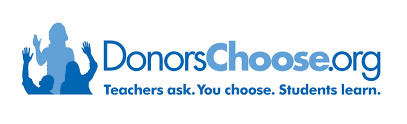

# Introduction

Donorschoose.org is a US-based non-profit organization that allows individuals to donate directly to public school classroom projects.Founded in 2000 by former public school teacher Charles Best, DonorsChoose.org was among the first civic crowdfunding platforms of its kind. The organization has been given Charity Navigator’s highest rating every year since 2005.In January 2018, they announced that 1 million projects had been funded.To get students what they need to learn, the team at DonorsChoose.org needs to be able to connect donors with the projects that most inspire them.

## Problem Statement

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the assignment is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>


# Importing Libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

C:\Users\aksha\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\aksha\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Directory List

In [2]:
import os 
os.chdir("D:\\applied AI\\Donorchoose")

# About the dataset

The train_data.csv is the dataset provided by the DonorsChoose containin features as follows :-


Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

## Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_4:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


# Reading the data

In [3]:
train_data=pd.read_csv("train_data.csv")
res_data=pd.read_csv("resources.csv")

In [4]:
print("number of datapoints=",train_data.shape) #shape will tell us the number of projects we have which is 109248
print("columns/attributes name=",train_data.columns)
print(train_data.head(3))

number of datapoints= (109248, 17)
columns/attributes name= Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')
   Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grade

In [5]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
# Replacing datetime columns to date column
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(train_data.columns)] #if x encounters column name project_submitted_datetime it will replace by date 
#so a new column Date is created

#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/40-84039
train_data['Date'] = pd.to_datetime(train_data['project_submitted_datetime']) #pd.to_datetime converts argument to datetime
train_data.drop('project_submitted_datetime', axis=1, inplace=True) #dropping the column project_submitted_date
train_data.sort_values(by=['Date'], inplace=True)#sorting the dataframe by date


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
train_data = train_data[cols] #adding the new column


train_data.head(2) #displaying the dataframe

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   
76127           UT 2016-04-27 00:31:25             Grades 3-5   

      project_subject_categories            project_subject_subcategories  \
55660             Math & Science  Applied Sciences, Health & Life Science   
76127              Special Needs                            Special Needs   

                                      project_title  \
55660  Engineering STEAM into the Primary Classroom   
76127                       Sensory Tools for Focus   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   

       teacher_number_of_previously_posted_projects  project_is_approved  
55660                                            53                    1  
76127                                             4                    1

In [6]:
print("datapoints in resources=",res_data.shape) 
print("attributes of resources=",res_data.columns)
print(res_data.head(3))

datapoints in resources= (1541272, 4)
attributes of resources= Index(['id', 'description', 'quantity', 'price'], dtype='object')
        id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   

    price  
0  149.00  
1   14.95  
2    8.45  


In [7]:
#Refer-> https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/

price_data = res_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index() #grouping is done on the basis of ids and agggreating the sum of price and quantity column

#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html?highlight=merge#pandas.merge
train_data = train_data.merge(price_data, on='id', how='left')
print(train_data.head(1))

   Unnamed: 0       id                        teacher_id teacher_prefix  \
0        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   

  school_state                Date project_grade_category  \
0           CA 2016-04-27 00:27:36          Grades PreK-2   

  project_subject_categories            project_subject_subcategories  \
0             Math & Science  Applied Sciences, Health & Life Science   

                                  project_title  \
0  Engineering STEAM into the Primary Classroom   

                                     project_essay_1  \
0  I have been fortunate enough to use the Fairy ...   

                                     project_essay_2  \
0  My students come from a variety of backgrounds...   

                                     project_essay_3  \
0  Each month I try to do several science or STEM...   

                                     project_essay_4  \
0  It is challenging to develop high quality scie...   

                        

In [8]:
#Refer for documentation: https://www.geeksforgeeks.org/python-pandas-index-value_counts/
approved_not_approved=train_data['project_is_approved'].value_counts()
print(approved_not_approved)
print("*"*50)
approved_not_approved1=train_data['project_is_approved'].value_counts(normalize=True)
print("in percentage=",approved_not_approved1)

1    92706
0    16542
Name: project_is_approved, dtype: int64
**************************************************
in percentage= 1    0.848583
0    0.151417
Name: project_is_approved, dtype: float64


# Feature Preprocessing

## Preprocessing of project_subject_categories

In [9]:
#Refer ->https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
#Refer for documentation ->https://www.programiz.com/python-programming/methods/string/strip
categories = list(train_data['project_subject_categories'].values) #creating a list of  all the values in project subject categories
clean_cat=[]
for i in categories: #taking each category at a time
    temp="" #creating a empty string
    for j in i.split(","): # splitting each word separated by a comma
        if 'The' in j.split():
            j=j.replace('The',"") #replacing the every occurence of "The" with ""
        j=j.replace(" ","") #replacing every white space with ""
        temp+=j.strip()+" " #removing all leading and trailing whitespaces and then adding a white space at the end
        temp = temp.replace('&','') #replacing & with "_"
        temp=temp.lower()
    clean_cat.append(temp.strip())
    #showing the result
print(clean_cat[23])

mathscience


In [10]:
train_data['clean_categories']=clean_cat #creating a new column as clean_categories
train_data.drop(['project_subject_categories'], axis=1,inplace=True) #dropping the subject category

In [11]:
# Counting number of words in a corpus/clean_categories
#Refer ->https://stackoverflow.com/questions/8139239/how-to-count-words-in-a-corpus-document
from collections import Counter
my_counter = Counter()
for word in train_data['clean_categories'].values:
    my_counter.update(word.split())
    
print(dict(my_counter)) #printing the dictionary
sortd=sorted(my_counter.items()) #with sorted function on dictionary it sorts in aplhabetical order of value
print("="*50)
print(sortd)

# Refer -> sorting dictionary in python by value : https://www.geeksforgeeks.org/python-sort-python-dictionaries-by-key-or-value/
#https://www.geeksforgeeks.org/ways-sort-list-dictionaries-values-python-using-lambda-function/
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv:(kv[1] ,kv[0])))

{'mathscience': 41421, 'specialneeds': 13642, 'literacylanguage': 52239, 'appliedlearning': 12135, 'historycivics': 5914, 'musicarts': 10293, 'healthsports': 14223, 'warmth': 1388, 'carehunger': 1388}
[('appliedlearning', 12135), ('carehunger', 1388), ('healthsports', 14223), ('historycivics', 5914), ('literacylanguage', 52239), ('mathscience', 41421), ('musicarts', 10293), ('specialneeds', 13642), ('warmth', 1388)]


## Preprocessing of project_subject_subcategories

In [12]:
#Refer ->https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
#Refer for documentation ->https://www.programiz.com/python-programming/methods/string/strip
subcategories = list(train_data['project_subject_subcategories'].values) #creating a list of  all the values in project subject categories
clean_subcat=[]
for i in subcategories: #taking each category at a time
    temp="" #creating a empty string
    for j in i.split(","): # splitting each word separated by a comma
        if 'The' in j.split():
            j=j.replace('The',"") #replacing the every occurence of "The" with ""
        j=j.replace(" ","") #replacing every white space with ""
        temp+=j.strip()+" " #removing all leading and trailing whitespaces and then adding a white space at the end
        temp = temp.replace('&','') #replacing & with "_"
        temp=temp.lower()
    clean_subcat.append(temp.strip())
    #showing the result
print(clean_subcat[24])

specialneeds


In [13]:
train_data['clean_subcategories']=clean_subcat #creating a new column as clean_categories
train_data.drop(['project_subject_subcategories'], axis=1,inplace=True) #dropping the subject category

In [14]:
# Counting number of words in a corpus/clean_categories
#Refer ->https://stackoverflow.com/questions/8139239/how-to-count-words-in-a-corpus-document
from collections import Counter
my_counter1 = Counter()
for word in train_data['clean_subcategories'].values:
    my_counter1.update(word.split())
    
print(dict(my_counter1)) #printing the dictionary
sortd1=sorted(my_counter1.items()) #with sorted function on dictionary it sorts in aplhabetical order of value
print("="*50)
print(sortd1)

# Refer -> sorting dictionary in python by value : https://www.geeksforgeeks.org/python-sort-python-dictionaries-by-key-or-value/
#https://www.geeksforgeeks.org/ways-sort-list-dictionaries-values-python-using-lambda-function/
subcat_dict = dict(my_counter1)
sorted_subcat_dict = dict(sorted(subcat_dict.items(), key=lambda kv:(kv[1] ,kv[0])))

{'appliedsciences': 10816, 'healthlifescience': 4235, 'specialneeds': 13642, 'literacy': 33700, 'earlydevelopment': 4254, 'mathematics': 28074, 'socialsciences': 1920, 'historygeography': 3171, 'esl': 4367, 'extracurricular': 810, 'visualarts': 6278, 'environmentalscience': 5591, 'literaturewriting': 22179, 'gymfitness': 4509, 'music': 3145, 'teamsports': 2192, 'performingarts': 1961, 'collegecareerprep': 2568, 'other': 2372, 'charactereducation': 2065, 'foreignlanguages': 890, 'healthwellness': 10234, 'civicsgovernment': 815, 'economics': 269, 'communityservice': 441, 'financialliteracy': 568, 'nutritioneducation': 1355, 'parentinvolvement': 677, 'warmth': 1388, 'carehunger': 1388}
[('appliedsciences', 10816), ('carehunger', 1388), ('charactereducation', 2065), ('civicsgovernment', 815), ('collegecareerprep', 2568), ('communityservice', 441), ('earlydevelopment', 4254), ('economics', 269), ('environmentalscience', 5591), ('esl', 4367), ('extracurricular', 810), ('financialliteracy', 5

## Text Preprocessing


First we have to merge all the essay columns into a single column and then count the number of words in essay's of approved projects and essay's of rejected projects

In [15]:
# merge two column text dataframe: https://stackoverflow.com/questions/19377969/combine-two-columns-of-text-in-dataframe-in-pandas-python
train_data["project_essay"] = train_data["project_essay_1"].map(str) +train_data["project_essay_2"].map(str)+train_data["project_essay_3"].map(str) +  train_data["project_essay_4"].map(str)
            #Here the .map(str) converts string to all the coulmns in project_eassy_1/2/3/4
print(train_data['project_essay'].head(3))

0    I have been fortunate enough to use the Fairy ...
1    Imagine being 8-9 years old. You're in your th...
2    Having a class of 24 students comes with diver...
Name: project_essay, dtype: object


### Essay Text

In [16]:
# printing some random essays.
print(train_data['project_essay'].values[10])
print("="*50)
print(train_data['project_essay'].values[20000])
print("="*50)
print(train_data['project_essay'].values[942])
print("="*50)
print(train_data['project_essay'].values[451])
print("="*50)
print(train_data['project_essay'].values[99])
print("="*50)


My students yearn for a classroom environment that matches their desire to learn. With education changing daily, we need a classroom that can meet the needs of all of my first graders.I have the privilege of teaching an incredible group of six and seven year olds who absolutely LOVE to learn. I am completely blown away by their love for learning. Each day is a new adventure as they enjoy learning from nonfiction text and hands on activities. Many of my students are very active learners who benefit from kinesthetic activities. Sometimes learning, while sitting in a seat, is difficult. I want every child the opportunity to focus their energy in order to do their best in school!Ideally, I would love to delve right into \"flexible seating\" where students are provided many different seating options (chairs, hokki stools, on mats on the ground, etc.) and they have the freedom to choose which ever seat they feel they need. My student would be able to choose which seating option will best hel

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
test = decontracted(train_data['project_essay'].values[20000])
print(test)
print("="*50)

\"A person is a person, no matter how small.\" (Dr.Seuss) I teach the smallest students with the biggest enthusiasm for learning. My students learn in many different ways using all of our senses and multiple intelligences. I use a wide range of techniques to help all my students succeed. \r\nStudents in my class come from a variety of different backgrounds which makes for wonderful sharing of experiences and cultures, including Native Americans.\r\nOur school is a caring community of successful learners which can be seen through collaborative student project based learning in and out of the classroom. Kindergarteners in my class love to work with hands-on materials and have many different opportunities to practice a skill before it is mastered. Having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum.Montana is the perfect place to learn about agriculture and nutrition. My students love to role play in our pretend kitchen in the ear

In [19]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
test = test.replace('\\r', ' ')
test = test.replace('\\"', ' ')
test = test.replace('\\n', ' ')
print(test)

 A person is a person, no matter how small.  (Dr.Seuss) I teach the smallest students with the biggest enthusiasm for learning. My students learn in many different ways using all of our senses and multiple intelligences. I use a wide range of techniques to help all my students succeed.   Students in my class come from a variety of different backgrounds which makes for wonderful sharing of experiences and cultures, including Native Americans.  Our school is a caring community of successful learners which can be seen through collaborative student project based learning in and out of the classroom. Kindergarteners in my class love to work with hands-on materials and have many different opportunities to practice a skill before it is mastered. Having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum.Montana is the perfect place to learn about agriculture and nutrition. My students love to role play in our pretend kitchen in the early chi

In [20]:
#remove special character: https://stackoverflow.com/a/5843547/4084039
test = re.sub('[^A-Za-z0-9]+', ' ', test) #square bracket creates either or set; + signifes 1 or more character
print(test)

 A person is a person no matter how small Dr Seuss I teach the smallest students with the biggest enthusiasm for learning My students learn in many different ways using all of our senses and multiple intelligences I use a wide range of techniques to help all my students succeed Students in my class come from a variety of different backgrounds which makes for wonderful sharing of experiences and cultures including Native Americans Our school is a caring community of successful learners which can be seen through collaborative student project based learning in and out of the classroom Kindergarteners in my class love to work with hands on materials and have many different opportunities to practice a skill before it is mastered Having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum Montana is the perfect place to learn about agriculture and nutrition My students love to role play in our pretend kitchen in the early childhood classroom

In [21]:
s=set(stopwords.words('english'))
print(s)

{'does', 'against', "should've", 'of', 'mightn', "shan't", 'had', 'why', "hadn't", 'off', 'on', 'few', 'these', 'as', 'just', "mightn't", 'have', 'isn', 'how', 'he', 'their', 'some', "she's", 'to', 'now', 'couldn', 'more', "needn't", 'most', 'doing', 'up', 'here', 'm', 'that', 'where', 'into', 'y', 'only', 'can', 'itself', 'for', 'will', 'a', 'are', 'those', "won't", 'if', 'doesn', "didn't", 'be', 'or', 'through', 'hasn', 'yourselves', 'the', 'what', 'll', 'her', 'until', 'who', 'she', "you'll", 'ain', 'ourselves', 'and', 'before', 'me', 'hadn', 'haven', "wasn't", 'having', 'herself', 'you', "you're", 'o', 'is', 'very', 'because', 'our', 'don', 'between', 'ma', 'mustn', 'wasn', 'yours', 'shouldn', 'been', 'himself', 'then', "wouldn't", 'after', 'so', 'above', 'there', 'over', 'this', 'his', 'am', 'from', 'again', 've', 'him', 'once', 'own', 'ours', 'than', 'was', 'about', 'they', 'same', 're', 'an', 'further', 'when', 'won', 'wouldn', 'it', 'not', 'myself', 'out', 'i', 'each', 'should'

In [22]:
#Combining all the above statments to transform our text in a clean text
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(train_data['project_essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent=sent.lower()
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in s)
    preprocessed_essays.append(sent.strip())

100%|████████████████████████████████████████████████████████████████████████| 109248/109248 [00:15<00:00, 7256.70it/s]


In [23]:
#printing the text after preprocessing
preprocessed_essays[0]

'fortunate enough use fairy tale stem kits classroom well stem journals students really enjoyed would love implement lakeshore stem kits classroom next school year provide excellent engaging stem lessons students come variety backgrounds including language socioeconomic status many lot experience science engineering kits give materials provide exciting opportunities students month try several science stem steam projects would use kits robot help guide science instruction engaging meaningful ways adapt kits current language arts pacing guide already teach material kits like tall tales paul bunyan johnny appleseed following units taught next school year implement kits magnets motion sink vs float robots often get units know teaching right way using right materials kits give additional ideas strategies lessons prepare students science challenging develop high quality science activities kits give materials need provide students science activities go along curriculum classroom although thin

In [24]:
train_data['preprocessed_essays']=preprocessed_essays
train_data.drop(['project_essay'], axis=1,inplace=True)

### Project title text

In [25]:
# Printing some random project title
# printing some random essays.
print(train_data['project_title'].values[7])
print("="*50)
print(train_data['project_title'].values[9])
print("="*50)
print(train_data['project_title'].values[16])
print("="*50)
print(train_data['project_title'].values[23])
print("="*50)

21st Century Learning with Multimedia
Dash and Dot Robotic Duo Needed
Help us travel the world...VIRTUALLY!
Techies in Training


In [26]:
from tqdm import tqdm
preprocessed_title = []
# tqdm is for printing the status bar
for title in tqdm(train_data['project_title'].values):
    test1 = decontracted(title)
    test1 = test1.replace('\\r', ' ')
    test1 = test1.replace('\\"', ' ')
    test1 = test1.replace('\\n', ' ')
    test1 = re.sub('[^A-Za-z0-9]+', ' ', test1)
    test1=test1.lower()
    # https://gist.github.com/sebleier/554280
    test1 = ' '.join(e for e in test1.split() if e not in s)
    preprocessed_title.append(test1.strip())

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:01<00:00, 69371.63it/s]


In [27]:
preprocessed_title[0]

'engineering steam primary classroom'

In [28]:
train_data['preprocessed_title']=preprocessed_title
train_data.drop(['project_title'], axis=1,inplace=True)

## Category Preprocessing

### Teacher Prefix

In [29]:
train_data['teacher_prefix'].head(5) #printing the first 5 values to see what preprocessing should be made

0    Mrs.
1     Ms.
2    Mrs.
3    Mrs.
4    Mrs.
Name: teacher_prefix, dtype: object

Need to convert it into lowercase as well as remove the punctuation at the last

In [30]:
from tqdm import tqdm
import string
preprocessed_prefix=[]
for prefix in tqdm(train_data['teacher_prefix'].values):
    test=str(prefix).strip(".")
    test=test.lower()
    preprocessed_prefix.append(test)


100%|█████████████████████████████████████████████████████████████████████| 109248/109248 [00:00<00:00, 1319653.49it/s]


In [31]:
preprocessed_prefix[3]

'mrs'

In [32]:
train_data['preprocessed_prefix']=preprocessed_prefix
#train_data.drop(['teacher_prefix'], axis=1,inplace=True)

### Grade Category

In [33]:
train_data['project_grade_category'].head(5) #printing the first 5 values to see what preprocessing should be made

0    Grades PreK-2
1       Grades 3-5
2    Grades PreK-2
3    Grades PreK-2
4       Grades 3-5
Name: project_grade_category, dtype: object

In [34]:
train_data['project_grade_category'].value_counts()


Grades PreK-2    44225
Grades 3-5       37137
Grades 6-8       16923
Grades 9-12      10963
Name: project_grade_category, dtype: int64

In [35]:
preprocessed_grade=[]
for grade in tqdm(train_data['project_grade_category'].values):
    grade=grade.strip(" ")
    grade=grade.replace(" ", "_")
    grade=grade.replace("-","_")
    preprocessed_grade.append(grade)

100%|█████████████████████████████████████████████████████████████████████| 109248/109248 [00:00<00:00, 1063136.62it/s]


In [36]:
preprocessed_grade[0:5]

['Grades_PreK_2', 'Grades_3_5', 'Grades_PreK_2', 'Grades_PreK_2', 'Grades_3_5']

In [37]:
train_data['preprocessed_grade']=preprocessed_grade
train_data.drop(['project_grade_category'], axis=1,inplace=True)

### project_resource_summary

In [38]:
train_data['project_resource_summary'].head(5)

0    My students need STEM kits to learn critical s...
1    My students need Boogie Boards for quiet senso...
2    My students need a mobile listening center to ...
3    My students need flexible seating in the class...
4    My students need copies of the New York Times ...
Name: project_resource_summary, dtype: object

In [39]:
from tqdm import tqdm
preprocessed_resource = []
# tqdm is for printing the status bar
for resource in tqdm(train_data['project_resource_summary'].values):
    sent = decontracted(resource)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent=sent.lower()
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in s)
    preprocessed_resource.append(sent.strip())
    

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:02<00:00, 43228.14it/s]


In [40]:
preprocessed_resource[0:5]

['students need stem kits learn critical science engineering skills kits focus important science concepts robot works engineering skills',
 'students need boogie boards quiet sensory breaks putty sensory input focus',
 'students need mobile listening center able enhance learning',
 'students need flexible seating classroom choose comfortable learn best',
 'students need copies new york times best seller wonder book okay think deeply compare contrast structures']

In [41]:
train_data['preprocessed_resource']=preprocessed_resource
train_data.drop(['project_resource_summary'], axis=1,inplace=True)

Dropping some unimportant features like id teachers id etc

In [42]:
train_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'teacher_number_of_previously_posted_projects',
       'project_is_approved', 'price', 'quantity', 'clean_categories',
       'clean_subcategories', 'preprocessed_essays', 'preprocessed_title',
       'preprocessed_prefix', 'preprocessed_grade', 'preprocessed_resource'],
      dtype='object')

In [43]:
X=train_data.drop(columns=['id',"teacher_id","Date",'project_essay_1','project_essay_2','project_essay_3','project_essay_4'])

In [44]:
print(X.columns)
print("*"*50)
print(X.head())

Index(['Unnamed: 0', 'teacher_prefix', 'school_state',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'price', 'quantity', 'clean_categories', 'clean_subcategories',
       'preprocessed_essays', 'preprocessed_title', 'preprocessed_prefix',
       'preprocessed_grade', 'preprocessed_resource'],
      dtype='object')
**************************************************
   Unnamed: 0 teacher_prefix school_state  \
0        8393           Mrs.           CA   
1       37728            Ms.           UT   
2       74477           Mrs.           CA   
3      100660           Mrs.           GA   
4       33679           Mrs.           WA   

   teacher_number_of_previously_posted_projects  project_is_approved   price  \
0                                            53                    1  725.05   
1                                             4                    1  213.03   
2                                            10                    1  329.00   
3 

In [45]:
y=X['project_is_approved']

In [46]:
X=X.drop(columns=['project_is_approved','teacher_prefix'])

In [47]:
print(X.shape)
print("="*50)
print(y.shape)


(109248, 12)
(109248,)


# Data Splitting into train,cv and test

In [228]:
# ============================== loading libraries ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
# =============================================================================================

In [229]:
# split the data set into train and test
#how to stratify using knn->https://stackoverflow.com/questions/34842405/parameter-stratify-from-method-train-test-split-scikit-learn
X_1, X_test, y_1, y_test =model_selection.train_test_split(X,y, test_size=0.33, random_state=5,stratify= y)#random spliiting of data into test and train

In [230]:
X_train, X_cv, y_train, y_cv = train_test_split(X_1, y_1, test_size=0.33,random_state=5,stratify= y_1) # this is random splitting of train data into train anc cross-validation

In [231]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

(49041, 12) (49041,)
(24155, 12) (24155,)
(36052, 12) (36052,)


# Vectorization

## One-Hot encoding of categorical feature

### Category Feature

In [232]:
vectorizer_cat = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True) #creating vocabulary
vectorizer_cat.fit(X_train['clean_categories'].values) #learning from the train data
print(vectorizer_cat.get_feature_names())
print('='*50)
categories_ohe_train=vectorizer_cat.transform(X_train['clean_categories'].values)#applying learned parameters to train,test and cv values
print("Shape of train data after one hot encoding",categories_ohe_train.shape)
print("train data after one hot encoding",categories_ohe_train[0:5, :])
categories_ohe_cv=vectorizer_cat.transform(X_cv['clean_categories'].values)
print('='*50)
print("Shape of CV data after one hot encoding",categories_ohe_cv.shape)
print("CV data after one hot encoding",categories_ohe_cv[0:5, :])
categories_ohe_test=vectorizer_cat.transform(X_test['clean_categories'].values)
print('='*50)
print("Shape of test data after one hot encoding",categories_ohe_test.shape)
print("test data after one hot encoding",categories_ohe_test[0:5, :])

['carehunger', 'warmth', 'historycivics', 'musicarts', 'appliedlearning', 'specialneeds', 'healthsports', 'mathscience', 'literacylanguage']
Shape of train data after one hot encoding (49041, 9)
train data after one hot encoding   (0, 8)	1
  (1, 8)	1
  (2, 0)	1
  (2, 1)	1
  (3, 7)	1
  (4, 2)	1
Shape of CV data after one hot encoding (24155, 9)
CV data after one hot encoding   (0, 7)	1
  (1, 2)	1
  (1, 4)	1
  (2, 8)	1
  (3, 7)	1
  (4, 6)	1
Shape of test data after one hot encoding (36052, 9)
test data after one hot encoding   (0, 5)	1
  (0, 8)	1
  (1, 7)	1
  (2, 4)	1
  (2, 8)	1
  (3, 7)	1
  (4, 8)	1


### Sub-Category feature

In [233]:
vectorizer_sub_cat = CountVectorizer(vocabulary=list(sorted_subcat_dict.keys()), lowercase=False, binary=True)
vectorizer_sub_cat.fit(X_train['clean_subcategories'].values)
print(vectorizer_sub_cat.get_feature_names())
print('='*50)
subcategories_ohe_train=vectorizer_sub_cat.transform(X_train['clean_subcategories'].values)#applying learned parameters to train,test and cv values
print("Shape of train data after one hot encoding",subcategories_ohe_train.shape)
print("train data after one hot encoding",subcategories_ohe_train[0:5,:])
subcategories_ohe_cv=vectorizer_sub_cat.transform(X_cv['clean_subcategories'].values)
print('='*50)
print("Shape of CV data after one hot encoding",subcategories_ohe_cv.shape)
print("CV data after one hot encoding",subcategories_ohe_cv[0:5,:])
subcategories_ohe_test=vectorizer_sub_cat.transform(X_test['clean_subcategories'].values)
print('='*50)
print("Shape of test data after one hot encoding",subcategories_ohe_test.shape)
print("test data after one hot encoding",subcategories_ohe_test[0:5,:])

['economics', 'communityservice', 'financialliteracy', 'parentinvolvement', 'extracurricular', 'civicsgovernment', 'foreignlanguages', 'nutritioneducation', 'carehunger', 'warmth', 'socialsciences', 'performingarts', 'charactereducation', 'teamsports', 'other', 'collegecareerprep', 'music', 'historygeography', 'healthlifescience', 'earlydevelopment', 'esl', 'gymfitness', 'environmentalscience', 'visualarts', 'healthwellness', 'appliedsciences', 'specialneeds', 'literaturewriting', 'mathematics', 'literacy']
Shape of train data after one hot encoding (49041, 30)
train data after one hot encoding   (0, 27)	1
  (1, 27)	1
  (2, 8)	1
  (2, 9)	1
  (3, 22)	1
  (4, 2)	1
  (4, 10)	1
Shape of CV data after one hot encoding (24155, 30)
CV data after one hot encoding   (0, 22)	1
  (1, 15)	1
  (1, 17)	1
  (2, 29)	1
  (3, 28)	1
  (4, 13)	1
  (4, 24)	1
Shape of test data after one hot encoding (36052, 30)
test data after one hot encoding   (0, 6)	1
  (0, 26)	1
  (1, 22)	1
  (1, 25)	1
  (2, 19)	1
  (2

### School-State feature

In [234]:
#counting number of words in the project grade category and then coverting into dictionary
from collections import Counter
my_counter=Counter()
for state in train_data['school_state'].values:
    my_counter.update(state.split())
    
#Converting to dictionary
school_state_dict=dict(my_counter)
#sorting
sorted_school_state_dict=dict(sorted(school_state_dict.items(),key=lambda kv:(kv[1],kv[0])))

In [235]:
vectorizer_school = CountVectorizer(vocabulary=list(sorted_school_state_dict.keys()), lowercase=False, binary=True)
vectorizer_school.fit(X_train['school_state'].values)
print(vectorizer_school.get_feature_names())
print('='*50)
state_ohe_train=vectorizer_school.transform(X_train['school_state'].values)#applying learned parameters to train,test and cv values
print("Shape of train data after one hot encoding",state_ohe_train.shape)
print("train data after one hot encoding",state_ohe_train[0:5,:])
state_ohe_cv=vectorizer_school.transform(X_cv['school_state'].values)
print('='*50)
print("Shape of CV data after one hot encoding",state_ohe_cv.shape)
print("CV data after one hot encoding",state_ohe_cv[0:5,:])
state_ohe_test=vectorizer_school.transform(X_test['school_state'].values)
print('='*50)
print("Shape of test data after one hot encoding",state_ohe_test.shape)
print("test data after one hot encoding",state_ohe_test[0:5,:])

['VT', 'WY', 'ND', 'MT', 'RI', 'SD', 'NE', 'DE', 'AK', 'NH', 'WV', 'ME', 'HI', 'DC', 'NM', 'KS', 'IA', 'ID', 'AR', 'CO', 'MN', 'OR', 'KY', 'MS', 'NV', 'MD', 'CT', 'TN', 'UT', 'AL', 'WI', 'VA', 'AZ', 'NJ', 'OK', 'WA', 'MA', 'LA', 'OH', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA']
Shape of train data after one hot encoding (49041, 51)
train data after one hot encoding   (0, 44)	1
  (1, 49)	1
  (2, 12)	1
  (3, 50)	1
  (4, 32)	1
Shape of CV data after one hot encoding (24155, 51)
CV data after one hot encoding   (0, 23)	1
  (1, 22)	1
  (2, 42)	1
  (3, 40)	1
  (4, 41)	1
Shape of test data after one hot encoding (36052, 51)
test data after one hot encoding   (0, 45)	1
  (1, 47)	1
  (2, 30)	1
  (3, 25)	1
  (4, 13)	1


### Project_Grade feature

In [236]:
from collections import Counter
my_counter1 = Counter()
for word in train_data['preprocessed_grade'].values:
    my_counter1.update(word.split())
    
#converting to dictionary
project_grade_dict=dict(my_counter1)
#Now sorting the dictionary
sorted_project_grade_dict = dict(sorted(project_grade_dict.items(), key=lambda kv:(kv[1] ,kv[0])))
print(sorted_project_grade_dict)

{'Grades_9_12': 10963, 'Grades_6_8': 16923, 'Grades_3_5': 37137, 'Grades_PreK_2': 44225}


In [237]:
#How to remove values from a dictionary in python-> https://thispointer.com/different-ways-to-remove-a-key-from-dictionary-in-python/
if 'Grades' in sorted_project_grade_dict:
    del sorted_project_grade_dict['Grades']

print("Updated Dictionary :" , sorted_project_grade_dict)  

Updated Dictionary : {'Grades_9_12': 10963, 'Grades_6_8': 16923, 'Grades_3_5': 37137, 'Grades_PreK_2': 44225}


In [238]:
vectorizer_grade = CountVectorizer(vocabulary=list(sorted_project_grade_dict.keys()), lowercase=False, binary=True)
vectorizer_grade.fit(X_train['preprocessed_grade'].values)
print(vectorizer_grade.get_feature_names())
print('='*50)
grade_ohe_train=vectorizer_grade.transform(X_train['preprocessed_grade'].values)#applying learned parameters to train,test and cv values
print("Shape of train data after one hot encoding",grade_ohe_train.shape)
print("train data after one hot encoding",grade_ohe_train[0:5,:])
grade_ohe_cv=vectorizer_grade.transform(X_cv['preprocessed_grade'].values)
print('='*50)
print("Shape of CV data after one hot encoding",grade_ohe_cv.shape)
print("cv data after one hot encoding",grade_ohe_cv[0:5,:])
grade_ohe_test=vectorizer_grade.transform(X_test['preprocessed_grade'].values)
print('='*50)
print("Shape of test data after one hot encoding",grade_ohe_test.shape)
print("test data after one hot encoding",grade_ohe_test[0:5,:])

['Grades_9_12', 'Grades_6_8', 'Grades_3_5', 'Grades_PreK_2']
Shape of train data after one hot encoding (49041, 4)
train data after one hot encoding   (0, 0)	1
  (1, 2)	1
  (2, 2)	1
  (3, 3)	1
  (4, 1)	1
Shape of CV data after one hot encoding (24155, 4)
cv data after one hot encoding   (0, 2)	1
  (1, 0)	1
  (2, 3)	1
  (3, 3)	1
  (4, 0)	1
Shape of test data after one hot encoding (36052, 4)
test data after one hot encoding   (0, 1)	1
  (1, 2)	1
  (2, 3)	1
  (3, 3)	1
  (4, 3)	1


### Teacher-Prefix feature

In [239]:
train_data['preprocessed_prefix']= train_data['preprocessed_prefix'].fillna('missing')
print("="*50)
print(train_data['preprocessed_prefix'].value_counts())

mrs        57269
ms         38955
mr         10648
teacher     2360
dr            13
nan            3
Name: preprocessed_prefix, dtype: int64


In [240]:
from collections import Counter
my_counter1 = Counter()
for word in train_data['preprocessed_prefix'].values:
    my_counter1.update(word.split())
    
#converting to dictionary
teacher_prefix_dict=dict(my_counter1)
#Now sorting the dictionary
sorted_teacher_prefix_grade_dict = dict(sorted(teacher_prefix_dict.items(), key=lambda kv:(kv[1] ,kv[0])))
print(sorted_teacher_prefix_grade_dict)

{'nan': 3, 'dr': 13, 'teacher': 2360, 'mr': 10648, 'ms': 38955, 'mrs': 57269}


In [241]:
#to counter error: np.nan is an invalid document, expected byte or unicode string.
#https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document

vectorizer_prefix = CountVectorizer(vocabulary=list(sorted_teacher_prefix_grade_dict.keys()), lowercase=False, binary=True)
vectorizer_prefix.fit(X_train['preprocessed_prefix'].values.astype('U'))
print(vectorizer_prefix.get_feature_names())
print('='*50)
prefix_ohe_train=vectorizer_prefix.transform(X_train['preprocessed_prefix'].values.astype('U'))#applying learned parameters to train,test and cv values
print("Shape of train data after one hot encoding",prefix_ohe_train.shape)
print("train data after one hot encoding",prefix_ohe_train[0:5,:])
prefix_ohe_cv=vectorizer_prefix.transform(X_cv['preprocessed_prefix'].values.astype('U'))
print('='*50)
print("Shape of CV data after one hot encoding",prefix_ohe_cv.shape)
print("cv data after one hot encoding",prefix_ohe_cv[0:5,:])
prefix_ohe_test=vectorizer_prefix.transform(X_test['preprocessed_prefix'].values.astype('U'))
print('='*50)
print("Shape of test data after one hot encoding",prefix_ohe_test.shape)
print("test data after one hot encoding",prefix_ohe_test[0:5,:])


['nan', 'dr', 'teacher', 'mr', 'ms', 'mrs']
Shape of train data after one hot encoding (49041, 6)
train data after one hot encoding   (0, 3)	1
  (1, 5)	1
  (2, 4)	1
  (3, 5)	1
  (4, 5)	1
Shape of CV data after one hot encoding (24155, 6)
cv data after one hot encoding   (0, 5)	1
  (1, 3)	1
  (2, 4)	1
  (3, 3)	1
  (4, 4)	1
Shape of test data after one hot encoding (36052, 6)
test data after one hot encoding   (0, 5)	1
  (1, 4)	1
  (2, 4)	1
  (3, 4)	1
  (4, 4)	1


## Normalizing Numerical Features

#### Price features

In [242]:
from sklearn.preprocessing import Normalizer
price_scalar = Normalizer()
price_scalar.fit(X_train['price'].values.reshape(1,-1))


price_train=price_scalar.transform(X_train['price'].values.reshape(1,-1))
print("Shape of price train data after normalization",price_train.shape)
print("price train data after normalization",price_train[0:1])
print("="*50)
price_cv=price_scalar.transform(X_cv['price'].values.reshape(1, -1))
print("Shape of price CV data after normalization",price_cv.shape)
print("price cv data after normalization",price_cv[0:1])
print("="*50)
price_test=price_scalar.transform(X_test['price'].values.reshape(1 ,-1))
print("Shape of price test data after normalization",price_test.shape)
print("price test data after normalization",price_test[0:1])

Shape of price train data after normalization (1, 49041)
price train data after normalization [[0.00048689 0.00031167 0.00240483 ... 0.00253076 0.00389578 0.00197083]]
Shape of price CV data after normalization (1, 24155)
price cv data after normalization [[0.0012673  0.02562521 0.00240981 ... 0.0016012  0.00835091 0.00321995]]
Shape of price test data after normalization (1, 36052)
price test data after normalization [[0.01552693 0.00111198 0.00429254 ... 0.00451968 0.00102011 0.01211403]]


In [243]:
# Reshaping Again
price_train=price_train.reshape(-1,1)
print("after reshape",price_train.shape)
price_cv=price_cv.reshape(-1,1)
print("after reshape",price_cv.shape)
price_test=price_test.reshape(-1,1)
print("after reshape",price_test.shape)

after reshape (49041, 1)
after reshape (24155, 1)
after reshape (36052, 1)


### Quantity Feature

In [244]:
quantity_scalar = Normalizer()
quantity_scalar.fit(X_train['quantity'].values.reshape(1,-1)) # finding the mean and standard deviation of this data


quantity_train=quantity_scalar.transform(X_train['quantity'].values.reshape(1, -1))
print("Shape of quantity train data after normalization",quantity_train.shape)
print("quantity train data after normalization",quantity_train[0:1])
print("="*50)
quantity_cv=quantity_scalar.transform(X_cv['quantity'].values.reshape(1, -1))
print("Shape of quantity CV data after normalization",quantity_cv.shape)
print("quantity cv data after normalization",quantity_cv[0:1])
print("="*50)
quantity_test=quantity_scalar.transform(X_test['quantity'].values.reshape(1, -1))
print("Shape of quantity test data after normalization",quantity_test.shape)
print("quantity test data after normalization",quantity_test[0:1])

Shape of quantity train data after normalization (1, 49041)
quantity train data after normalization [[0.00210819 0.01503845 0.00520021 ... 0.00281093 0.00028109 0.00351366]]
Shape of quantity CV data after normalization (1, 24155)
quantity cv data after normalization [[0.00206929 0.00020693 0.00124158 ... 0.00082772 0.00227622 0.00103465]]
Shape of quantity test data after normalization (1, 36052)
quantity test data after normalization [[0.00017579 0.00193368 0.00070315 ... 0.00017579 0.00105473 0.00052737]]


In [245]:
# Reshaping Again
quantity_train=quantity_train.reshape(-1,1)
print("after reshape",price_train.shape)
quantity_cv=quantity_cv.reshape(-1,1)
print("after reshape",price_cv.shape)
quantity_test=quantity_test.reshape(-1,1)
print("after reshape",price_test.shape)

after reshape (49041, 1)
after reshape (24155, 1)
after reshape (36052, 1)


### Teacher number of previously posted projects feature

In [246]:
tnp_scalar = Normalizer()
tnp_scalar.fit(X_train["teacher_number_of_previously_posted_projects"].values.reshape(1,-1)) # finding the mean and standard deviation of this data

# Now standardize the data with above maen and variance.
tnp_train = tnp_scalar.transform(X_train["teacher_number_of_previously_posted_projects"].values.reshape(1, -1))
print(tnp_train.shape)
print("train data after normalization",tnp_train[0:1])
print('='*50)
tnp_cv = tnp_scalar.transform(X_cv["teacher_number_of_previously_posted_projects"].values.reshape(1, -1))
print(tnp_cv.shape)
print("cv data after normalization",tnp_cv[0:1])
print('='*50)
tnp_test = tnp_scalar.transform(X_test["teacher_number_of_previously_posted_projects"].values.reshape(1, -1))
print(tnp_test.shape)
print("test data after normalization",tnp_test[0:1])

(1, 49041)
train data after normalization [[0.         0.00090827 0.00105964 ... 0.00015138 0.         0.        ]]
(1, 24155)
cv data after normalization [[0.0006398  0.         0.         ... 0.00085307 0.00191941 0.        ]]
(1, 36052)
test data after normalization [[0.00052822 0.         0.0026411  ... 0.         0.         0.00052822]]


In [247]:
# Reshaping Again
tnp_train=tnp_train.reshape(-1,1)
print("after reshape",price_train.shape)
tnp_cv=tnp_cv.reshape(-1,1)
print("after reshape",price_cv.shape)
tnp_test=tnp_test.reshape(-1,1)
print("after reshape",price_test.shape)

after reshape (49041, 1)
after reshape (24155, 1)
after reshape (36052, 1)


## Vectorizing Text Data

### Bag of words(BoW)

#### Preprocessed Essay

In [68]:
model_essay_bow =  CountVectorizer(min_df=10)
model_essay_bow.fit(X_train["preprocessed_essays"])


train_bow_essay = model_essay_bow.transform(X_train["preprocessed_essays"])
print("Shape of matrix ",train_bow_essay.shape)
print("="*50)
cv_bow_essay=model_essay_bow.transform(X_cv["preprocessed_essays"]) #BoW of CV
print("Shape of matrix ",cv_bow_essay.shape)
print("="*50)
test_bow_essay = model_essay_bow.transform(X_test["preprocessed_essays"]) #BoW of Test
print("Shape of matrix ",test_bow_essay.shape)

Shape of matrix  (49041, 12015)
Shape of matrix  (24155, 12015)
Shape of matrix  (36052, 12015)


#### Preprocessed Title

In [69]:
model_title_bow =  CountVectorizer(min_df=10)
model_title_bow.fit(X_train["preprocessed_title"])
train_bow_title = model_title_bow.transform(X_train["preprocessed_title"])
print("Shape of matrix ",train_bow_title.shape)
print("="*50)
cv_bow_title=model_title_bow.transform(X_cv["preprocessed_title"]) #BoW of test
print("Shape of matrix ",cv_bow_title.shape)
print("="*50)
test_bow_title = model_title_bow.transform(X_test["preprocessed_title"]) #BoW of Cross Validation
print("Shape of matrix ",test_bow_title.shape)

Shape of matrix  (49041, 2010)
Shape of matrix  (24155, 2010)
Shape of matrix  (36052, 2010)


## Tf-idf vectorizer

### Tf-idf of Project_Essays

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
model_essay_tfidf = TfidfVectorizer(min_df=10)
model_essay_tfidf.fit(X_train["preprocessed_essays"])

train_tfidf_essay=model_essay_tfidf.transform(X_train["preprocessed_essays"])
print("Shape of matrix ",train_tfidf_essay.shape)
print("="*50)
cv_tfidf_essay=model_essay_tfidf.transform(X_cv["preprocessed_essays"]) #tfidf of CV
print("Shape of matrix ",cv_tfidf_essay.shape)
print("="*50)
test_tfidf_essay = model_essay_tfidf.transform(X_test["preprocessed_essays"]) #tfidf of Test
print("Shape of matrix ",test_tfidf_essay.shape)

Shape of matrix  (49041, 12015)
Shape of matrix  (24155, 12015)
Shape of matrix  (36052, 12015)


### Tf-idf of Project_Title

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
model_title_tfidf = TfidfVectorizer(min_df=10)
model_title_tfidf.fit(X_train["preprocessed_title"])

train_tfidf_title=model_title_tfidf.transform(X_train["preprocessed_title"])
print("Shape of matrix ",train_tfidf_title.shape)
print("="*50)
cv_tfidf_title=model_title_tfidf.transform(X_cv["preprocessed_title"]) #tfidf of CV
print("Shape of matrix ",cv_tfidf_title.shape)
print("="*50)
test_tfidf_title = model_title_tfidf.transform(X_test["preprocessed_title"]) #tfidf of Test
print("Shape of matrix ",test_tfidf_title.shape)

Shape of matrix  (49041, 2010)
Shape of matrix  (24155, 2010)
Shape of matrix  (36052, 2010)


## Average word2vector(avg w2v)

In [72]:
#https://stackoverflow.com/questions/49083826/get-trouble-to-load-glove-840b-300d-vector
import numpy as np
from tqdm import tqdm
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding='utf8')
    model = {}
    for line in tqdm(f):
        splitLine = line.split(' ')
        word = splitLine[0]
        embedding = np.asarray(splitLine[1:], dtype='float32')
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model

In [73]:
model = loadGloveModel('glove.840B.300d.txt')

Loading Glove Model


2196017it [02:41, 13568.61it/s]


Done. 2196016  words loaded!


In [74]:
words = []
for i in X_train["preprocessed_essays"]:
    words.extend(i.split(' '))

In [75]:
print("all the words in the corpus", len(words))
words = set(words)
print("the unique words in the corpus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our corpus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

train_words_corpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        train_words_corpus[i] = model[i]
print("word 2 vec length", len(train_words_corpus))

all the words in the corpus 6693865
the unique words in the corpus 41189
The number of words that are present in both glove vectors and our corpus 36109 ( 87.667 %)
word 2 vec length 36109


In [76]:
import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(train_words_corpus, f) # save training datasets into a pickle file for machine learning

In [77]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

### Train Essays

In [78]:
# average Word2Vec
# compute average word2vec for each test data

from tqdm import tqdm
avg_w2v_vectors_train = []; # the avg-w2v for each essays is stored in this list
for sentence in tqdm(X_train["preprocessed_essays"]): # for each essay
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a esssay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_train.append(vector)

print(len(avg_w2v_vectors_train))
print(len(avg_w2v_vectors_train[0]))

100%|██████████████████████████████████████████████████████████████████████████| 49041/49041 [00:15<00:00, 3093.95it/s]


49041
300


### Cross-Validation Essays

In [79]:
# average Word2Vec
# compute average word2vec for each CV data

from tqdm import tqdm
avg_w2v_vectors_cv = []; # the avg-w2v for each essays is stored in this list
for sentence in tqdm(X_cv["preprocessed_essays"]): # for each essay
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a esssay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_cv.append(vector)

print(len(avg_w2v_vectors_cv))
print(len(avg_w2v_vectors_cv[0]))

100%|██████████████████████████████████████████████████████████████████████████| 24155/24155 [00:08<00:00, 2955.04it/s]


24155
300


### Test Essays

In [80]:
# average Word2Vec
# compute average word2vec for each test data

from tqdm import tqdm
avg_w2v_vectors_test = []; # the avg-w2v for each essays is stored in this list
for sentence in tqdm(X_test["preprocessed_essays"]): # for each essay
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a esssay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_test.append(vector)

print(len(avg_w2v_vectors_test))
print(len(avg_w2v_vectors_test[0]))

100%|██████████████████████████████████████████████████████████████████████████| 36052/36052 [00:11<00:00, 3131.34it/s]


36052
300


### Train Titles

In [81]:
# average Word2Vec
# compute average word2vec for each training data

from tqdm import tqdm
avg_w2v_vectors_title_train = []; # the avg-w2v for each essays is stored in this list
for sentence in tqdm(X_train["preprocessed_title"]): # for each essay
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a esssay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_title_train.append(vector)

print(len(avg_w2v_vectors_title_train))
print(len(avg_w2v_vectors_title_train[0]))

100%|█████████████████████████████████████████████████████████████████████████| 49041/49041 [00:00<00:00, 59384.41it/s]


49041
300


### Cross-Validation Ttiles

In [82]:
# average Word2Vec
# compute average word2vec for each CV data

from tqdm import tqdm
avg_w2v_vectors_title_cv = []; # the avg-w2v for each essays is stored in this list
for sentence in tqdm(X_cv["preprocessed_title"]): # for each essay
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a esssay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_title_cv.append(vector)

print(len(avg_w2v_vectors_title_cv))
print(len(avg_w2v_vectors_title_cv[0]))

100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:00<00:00, 60393.10it/s]


24155
300


### Test Titles

In [83]:
# average Word2Vec
# compute average word2vec for each test data

from tqdm import tqdm
avg_w2v_vectors_title_test = []; # the avg-w2v for each essays is stored in this list
for sentence in tqdm(X_test["preprocessed_title"]): # for each essay
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a esssay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_title_test.append(vector)

print(len(avg_w2v_vectors_title_test))
print(len(avg_w2v_vectors_title_test[0]))

100%|█████████████████████████████████████████████████████████████████████████| 36052/36052 [00:00<00:00, 56567.53it/s]


36052
300


## Tf-idf weighted W2V(Using Pretrained Model for finding the tf-idf weighted word2vec)

### Train Essays

In [84]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train["preprocessed_essays"])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [85]:
# compute average word2vec for Training Data
from tqdm import tqdm
tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence
for sentence in tqdm(X_train["preprocessed_essays"]): # for each sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence
    for word in sentence.split(): # for each word in a sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 49041/49041 [01:26<00:00, 567.67it/s]


49041
300


### Cross-Validation Essays

In [86]:
# compute average word2vec for Cross Validation data
from tqdm import tqdm
tfidf_w2v_vectors_cv = []; # the avg-w2v for each sentence
for sentence in tqdm(X_cv["preprocessed_essays"]): # for each sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence
    for word in sentence.split(): # for each word in a sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_cv.append(vector)

print(len(tfidf_w2v_vectors_cv))
print(len(tfidf_w2v_vectors_cv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 24155/24155 [00:42<00:00, 568.23it/s]


24155
300


### Test Essays

In [87]:
# compute average word2vec for test data
from tqdm import tqdm
tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence
for sentence in tqdm(X_test["preprocessed_essays"]): # for each sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence
    for word in sentence.split(): # for each word in a sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 36052/36052 [01:03<00:00, 571.59it/s]


36052
300


### Train Titles

In [88]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train["preprocessed_title"])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [89]:
# compute average word2vec for Training Data
from tqdm import tqdm
tfidf_w2v_vectors_title_train = []; # the avg-w2v for each sentence
for sentence in tqdm(X_train["preprocessed_title"]): # for each sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence
    for word in sentence.split(): # for each word in a sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_title_train.append(vector)

print(len( tfidf_w2v_vectors_title_train))
print(len( tfidf_w2v_vectors_title_train[0]))

100%|█████████████████████████████████████████████████████████████████████████| 49041/49041 [00:01<00:00, 35734.74it/s]


49041
300


### Cross-Validation Titles

In [90]:
# compute average word2vec for Cross-Validation Data
from tqdm import tqdm
tfidf_w2v_vectors_title_cv = []; # the avg-w2v for each sentence
for sentence in tqdm(X_cv["preprocessed_title"]): # for each sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence
    for word in sentence.split(): # for each word in a sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_title_cv.append(vector)

print(len( tfidf_w2v_vectors_title_cv))
print(len( tfidf_w2v_vectors_title_cv[0]))

100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:00<00:00, 34646.24it/s]


24155
300


### Test titles

In [91]:
# compute average word2vec for Test Data
from tqdm import tqdm
tfidf_w2v_vectors_title_test = []; # the avg-w2v for each sentence
for sentence in tqdm(X_test["preprocessed_title"]): # for each sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence
    for word in sentence.split(): # for each word in a sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_title_test.append(vector)

print(len( tfidf_w2v_vectors_title_test))
print(len( tfidf_w2v_vectors_title_test[0]))

100%|█████████████████████████████████████████████████████████████████████████| 36052/36052 [00:01<00:00, 33010.59it/s]


36052
300


# Applying Linear SVM

## Set 1: Categorical Features,Numerical Features+Preprocessed Essay(BOW)+Preprocessed Title(BOW)

In [92]:
from scipy.sparse import hstack
X_tr=hstack((categories_ohe_train,subcategories_ohe_train,state_ohe_train,grade_ohe_train,prefix_ohe_train,price_train,quantity_train,tnp_train,train_bow_essay,train_bow_title)).tocsr()

X_cv=hstack((categories_ohe_cv,subcategories_ohe_cv,state_ohe_cv,grade_ohe_cv,prefix_ohe_cv,price_cv,quantity_cv,tnp_cv,cv_bow_essay,cv_bow_title)).tocsr()

X_te=hstack((categories_ohe_test,subcategories_ohe_test,state_ohe_test,grade_ohe_test,prefix_ohe_test,price_test,quantity_test,tnp_test,test_bow_essay,test_bow_title)).tocsr()

In [93]:
#checking the final matrix are of same dimension or not
print(X_tr.shape,y_train.shape)
print("="*50)
print(X_cv.shape,y_cv.shape)
print("="*50)
print(X_te.shape,y_test.shape)

(49041, 14128) (49041,)
(24155, 14128) (24155,)
(36052, 14128) (36052,)


### Using Brute Force for finding best Hyperparameter

#### Using L2 as a Regularization term

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

0.8171299462235406
0.6797213627329749
corresponding alpha 0.0001


  4%|███▎                                                                               | 1/25 [00:00<00:14,  1.68it/s]

0.8091753780073772
0.6822601699498191
corresponding alpha 0.00017782794100389227


  8%|██████▋                                                                            | 2/25 [00:01<00:14,  1.58it/s]

0.8179838680006299
0.6761297106478545
corresponding alpha 0.00031622776601683794


 12%|█████████▉                                                                         | 3/25 [00:01<00:13,  1.59it/s]

0.8201740306107771
0.6856583285648655
corresponding alpha 0.0005623413251903491


 16%|█████████████▎                                                                     | 4/25 [00:02<00:13,  1.58it/s]

0.8192110751670881
0.6840151448510967
corresponding alpha 0.001


 20%|████████████████▌                                                                  | 5/25 [00:03<00:12,  1.57it/s]

0.8193456142012541
0.6913707448545439
corresponding alpha 0.0017782794100389228


 24%|███████████████████▉                                                               | 6/25 [00:03<00:12,  1.54it/s]

0.8179511870237542
0.6995112377224129
corresponding alpha 0.0031622776601683794


 28%|███████████████████████▏                                                           | 7/25 [00:04<00:11,  1.55it/s]

0.8091767597368811
0.7087620452002987
corresponding alpha 0.005623413251903491


 32%|██████████████████████████▌                                                        | 8/25 [00:05<00:10,  1.61it/s]

0.799880786190497
0.7141855386332869
corresponding alpha 0.01


 36%|█████████████████████████████▉                                                     | 9/25 [00:05<00:09,  1.62it/s]

0.7843717575265994
0.7155807473483677
corresponding alpha 0.01778279410038923


 40%|████████████████████████████████▊                                                 | 10/25 [00:06<00:09,  1.62it/s]

0.7668027513826274
0.7130193084191597
corresponding alpha 0.03162277660168379


 44%|████████████████████████████████████                                              | 11/25 [00:06<00:08,  1.64it/s]

0.7489914491006283
0.7069549499923866
corresponding alpha 0.05623413251903491


 48%|███████████████████████████████████████▎                                          | 12/25 [00:07<00:07,  1.67it/s]

0.7303323732524479
0.6989418563895187
corresponding alpha 0.1


 52%|██████████████████████████████████████████▋                                       | 13/25 [00:08<00:07,  1.68it/s]

0.712424071617726
0.688602618960698
corresponding alpha 0.1778279410038923


 56%|█████████████████████████████████████████████▉                                    | 14/25 [00:08<00:06,  1.71it/s]

0.694177726785739
0.6771437687765506
corresponding alpha 0.31622776601683794


 60%|█████████████████████████████████████████████████▏                                | 15/25 [00:09<00:05,  1.68it/s]

0.6787030310259108
0.6655620349976854
corresponding alpha 0.5623413251903491


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:09<00:05,  1.70it/s]

0.6671830505862821
0.657920206865457
corresponding alpha 1.0


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [00:10<00:04,  1.69it/s]

0.6573710415189007
0.652162513810814
corresponding alpha 1.7782794100389228


 72%|███████████████████████████████████████████████████████████                       | 18/25 [00:10<00:04,  1.71it/s]

0.6401847275269867
0.6388715754844113
corresponding alpha 3.1622776601683795


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [00:11<00:03,  1.75it/s]

0.621949952657158
0.6231078374346959
corresponding alpha 5.623413251903491


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [00:12<00:02,  1.78it/s]

0.6176275662349188
0.6191645700482914
corresponding alpha 10.0


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:12<00:02,  1.80it/s]

0.6174496564266487
0.6192867266000834
corresponding alpha 17.78279410038923


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [00:13<00:01,  1.79it/s]

0.617607372597987
0.6190437675305724
corresponding alpha 31.622776601683793


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [00:13<00:01,  1.81it/s]

0.6174542239001732
0.6191061197991184
corresponding alpha 56.23413251903491


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [00:14<00:00,  1.83it/s]

0.6174764868954605
0.6190082691594554
corresponding alpha 100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.83it/s]


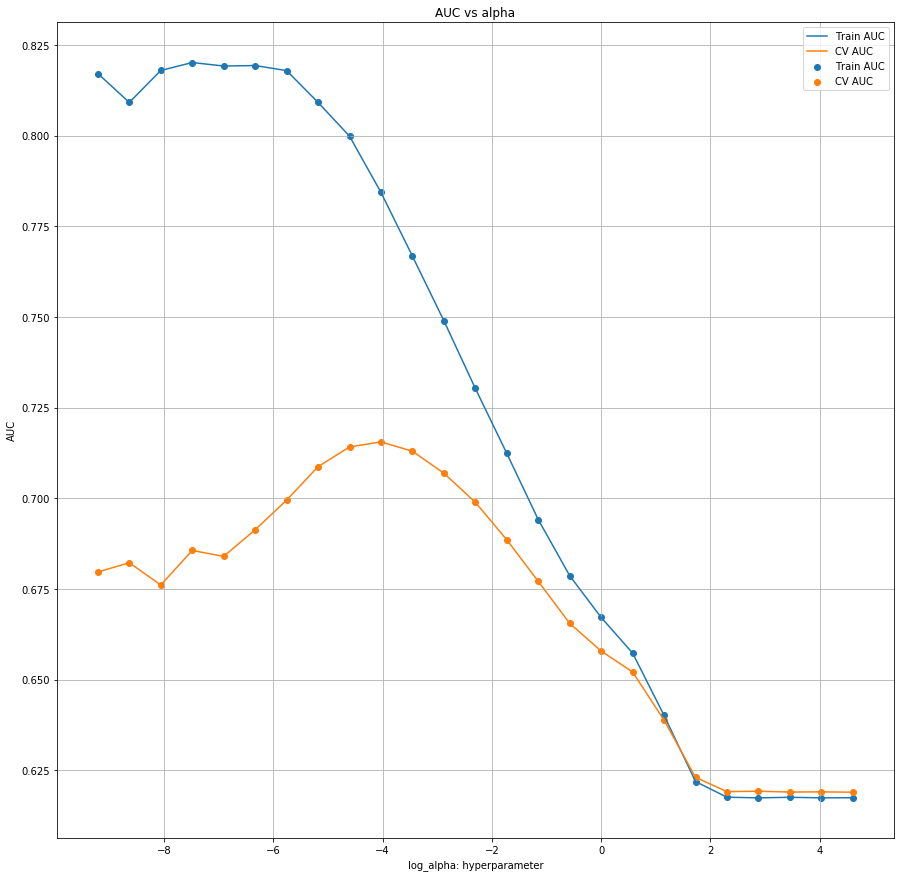

In [94]:
from sklearn.linear_model import SGDClassifier 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import math
alpha1=[]
train_auc = []
cv_auc = []
alpha=np.logspace(-4,2,25)
for i in tqdm(alpha):
    clf=SGDClassifier(loss='hinge',alpha=i,penalty='l2',class_weight='balanced')
    calibrated=CalibratedClassifierCV(clf ,method='isotonic',cv=3)
    calibrated.fit(X_tr,y_train)
    probs_train=calibrated.predict_proba(X_tr)[:,1]
    probs_cv=calibrated.predict_proba(X_cv)[:,1]
    train_auc.append(roc_auc_score(y_train,probs_train))#roc_auc_score->Compute(ROC AUC) from prediction scores.
    print(roc_auc_score(y_train,probs_train))
    cv_auc.append(roc_auc_score(y_cv, probs_cv))
    print(roc_auc_score(y_cv, probs_cv))
    print("corresponding alpha",i)

for i in alpha:
    j=math.log(i)
    alpha1.append(j)
    
plt.figure(figsize=(15,15))
plt.plot(alpha1, train_auc, label='Train AUC') #Plotting alpha vs auc of train
plt.scatter(alpha1, train_auc, label='Train AUC') #Scatter plot of alpha vs auc train

plt.plot(alpha1, cv_auc, label='CV AUC') #Plotting alpha vs auc of CV
plt.scatter(alpha1, cv_auc, label='CV AUC') #Scatter plot of alpha vs auc of CV

plt.legend() #adding legend
plt.xlabel("log_alpha: hyperparameter") #X axis-label
plt.ylabel("AUC")  #Y-axis label
plt.title("AUC vs alpha") #adding title of the plot
plt.grid()
plt.show()

#### Using L1 as a Regularization term

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

0.7908019189148705
0.6790626018110225
corresponding alpha 0.0001


  4%|███▎                                                                               | 1/25 [00:01<00:25,  1.06s/it]

0.7751832255837798
0.6701440729606386
corresponding alpha 0.00017782794100389227


  8%|██████▋                                                                            | 2/25 [00:02<00:24,  1.06s/it]

0.7569690714897461
0.6666399395014908
corresponding alpha 0.00031622776601683794


 12%|█████████▉                                                                         | 3/25 [00:03<00:23,  1.05s/it]

0.7334112646031739
0.668079384443037
corresponding alpha 0.0005623413251903491


 16%|█████████████▎                                                                     | 4/25 [00:04<00:22,  1.05s/it]

0.7153203562506385
0.66863244399575
corresponding alpha 0.001


 20%|████████████████▌                                                                  | 5/25 [00:05<00:20,  1.04s/it]

0.6958890537867818
0.6546167172435079
corresponding alpha 0.0017782794100389228


 24%|███████████████████▉                                                               | 6/25 [00:06<00:19,  1.02s/it]

0.6748780170686631
0.6482938517007989
corresponding alpha 0.0031622776601683794


 28%|███████████████████████▏                                                           | 7/25 [00:07<00:17,  1.02it/s]

0.6707033333237336
0.6534179768713905
corresponding alpha 0.005623413251903491


 32%|██████████████████████████▌                                                        | 8/25 [00:07<00:15,  1.08it/s]

0.6556073544122263
0.6472188153479856
corresponding alpha 0.01


 36%|█████████████████████████████▉                                                     | 9/25 [00:08<00:14,  1.13it/s]

0.6424558976696955
0.6290739783652836
corresponding alpha 0.01778279410038923


 40%|████████████████████████████████▊                                                 | 10/25 [00:09<00:12,  1.17it/s]

0.6090352813141406
0.6052794975789204
corresponding alpha 0.03162277660168379


 44%|████████████████████████████████████                                              | 11/25 [00:10<00:11,  1.22it/s]

0.5709459983544152
0.57563278147707
corresponding alpha 0.05623413251903491


 48%|███████████████████████████████████████▎                                          | 12/25 [00:10<00:10,  1.28it/s]

0.5604543547276296
0.5639201866416573
corresponding alpha 0.1


 52%|██████████████████████████████████████████▋                                       | 13/25 [00:11<00:09,  1.32it/s]

0.5381956324468788
0.5473800000976504
corresponding alpha 0.1778279410038923


 56%|█████████████████████████████████████████████▉                                    | 14/25 [00:12<00:08,  1.34it/s]

0.5
0.5
corresponding alpha 0.31622776601683794


 60%|█████████████████████████████████████████████████▏                                | 15/25 [00:13<00:07,  1.36it/s]

0.5
0.5
corresponding alpha 0.5623413251903491


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:13<00:06,  1.39it/s]

0.5
0.5
corresponding alpha 1.0


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [00:14<00:05,  1.41it/s]

0.499929018905069
0.49999019492567787
corresponding alpha 1.7782794100389228


 72%|███████████████████████████████████████████████████████████                       | 18/25 [00:15<00:04,  1.43it/s]

0.5
0.5
corresponding alpha 3.1622776601683795


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [00:15<00:04,  1.45it/s]

0.5
0.5
corresponding alpha 5.623413251903491


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [00:16<00:03,  1.46it/s]

0.5
0.5
corresponding alpha 10.0


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:17<00:02,  1.47it/s]

0.5
0.5
corresponding alpha 17.78279410038923


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [00:17<00:02,  1.48it/s]

0.5
0.5
corresponding alpha 31.622776601683793


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [00:18<00:01,  1.48it/s]

0.5
0.5
corresponding alpha 56.23413251903491


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [00:19<00:00,  1.49it/s]

0.5
0.5
corresponding alpha 100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.49it/s]


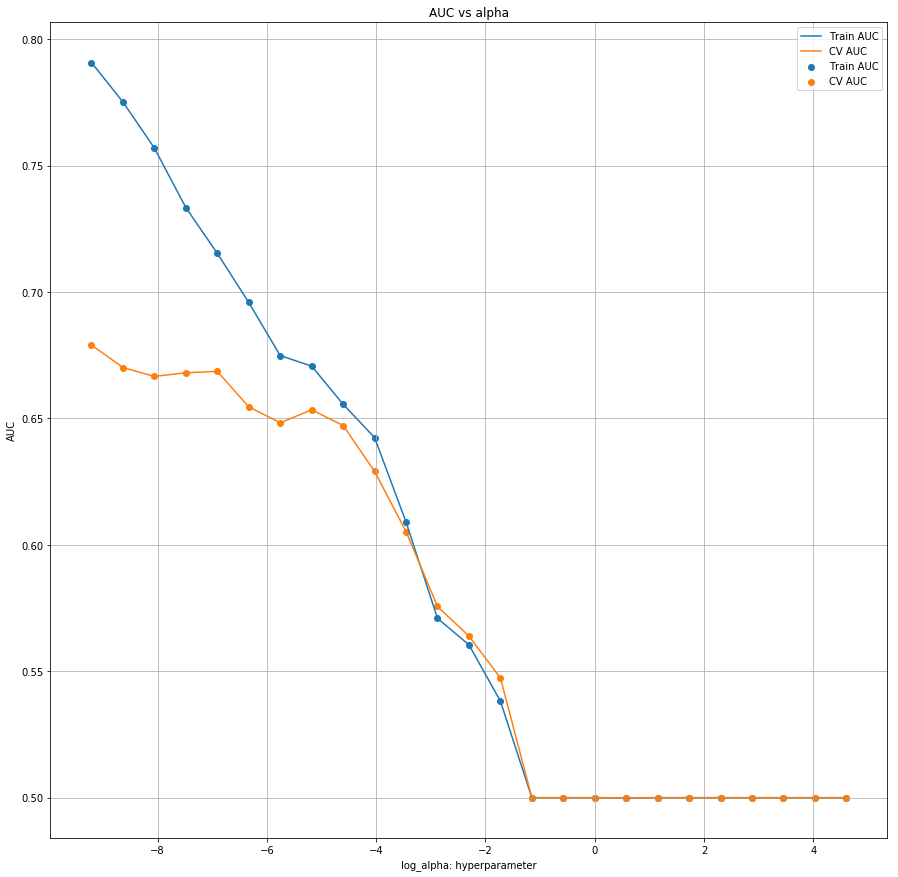

In [95]:
from sklearn.linear_model import SGDClassifier 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import math
alpha1=[]
train_auc = []
cv_auc = []
alpha=np.logspace(-4,2,25)
for i in tqdm(alpha):
    clf=SGDClassifier(loss='hinge',alpha=i,penalty='l1',class_weight='balanced')
    calibrated=CalibratedClassifierCV(clf ,method='isotonic',cv=3)
    calibrated.fit(X_tr,y_train)
    probs_train=calibrated.predict_proba(X_tr)[:,1]
    probs_cv=calibrated.predict_proba(X_cv)[:,1]
    train_auc.append(roc_auc_score(y_train,probs_train))#roc_auc_score->Compute(ROC AUC) from prediction scores.
    print(roc_auc_score(y_train,probs_train))
    cv_auc.append(roc_auc_score(y_cv, probs_cv))
    print(roc_auc_score(y_cv, probs_cv))
    print("corresponding alpha",i)

for i in alpha:
    j=math.log(i)
    alpha1.append(j)
    
plt.figure(figsize=(15,15))
plt.plot(alpha1, train_auc, label='Train AUC') #Plotting alpha vs auc of train
plt.scatter(alpha1, train_auc, label='Train AUC') #Scatter plot of alpha vs auc train

plt.plot(alpha1, cv_auc, label='CV AUC') #Plotting alpha vs auc of CV
plt.scatter(alpha1, cv_auc, label='CV AUC') #Scatter plot of alpha vs auc of CV

plt.legend() #adding legend
plt.xlabel("log_alpha: hyperparameter") #X axis-label
plt.ylabel("AUC")  #Y-axis label
plt.title("AUC vs alpha") #adding title of the plot
plt.grid()
plt.show()

#### L2 regularization is performing better than L1

### Testing on Test Data(using our best hyper parameter=0.005623413251903491) 

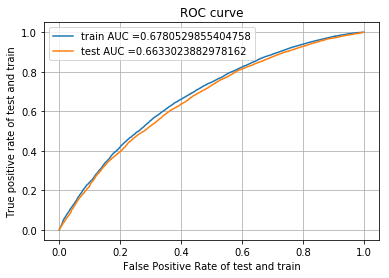

In [160]:
from sklearn.metrics import roc_curve,auc

clf=SGDClassifier(alpha=0.005623413251903491, penalty='l2')
calibrated=CalibratedClassifierCV(clf ,method='isotonic',cv=3)
calibrated.fit(X_tr,y_train)

#documentation of roc_curve ->https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
#roc_curve returns three values fpr,tpr and thresholds
probs_train=calibrated.predict_proba(X_tr)[:,1]
probs_test=calibrated.predict_proba(X_te)[:,1]
train_fpr,train_tpr,train_thresholds= roc_curve(y_train,probs_train)
test_fpr,test_tpr,test_thresholds= roc_curve(y_test,probs_test)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr))) #documentation of auc-> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("False Positive Rate of test and train") #plt.plot documentation ->https://matplotlib.org/3.1.0/tutorials/introductory/pyplot.html
plt.ylabel("True positive rate of test and train")
plt.title("ROC curve")
plt.grid()
plt.show()

### Confusion Matrix

In [161]:
df=pd.DataFrame({"fpr":train_fpr,"tpr":train_tpr,"threshold":train_thresholds})
print(df.head(3))
print(df.shape)

   fpr       tpr  threshold
0  0.0  0.000000   1.977577
1  0.0  0.000240   0.977577
2  0.0  0.000264   0.973007
(5967, 3)


In [162]:
df['Specificty']=1-df.fpr

In [163]:
df['Value']=df.tpr*df.Specificty

In [164]:
df.sort_values("Value", axis = 0, ascending = False, 
                 inplace = True, na_position ='first') 

In [165]:
df.head(3)

fpr       tpr  threshold  Specificty     Value
2720  0.377862  0.642196   0.846895    0.622138  0.399535
2719  0.377862  0.642100   0.846947    0.622138  0.399475
2718  0.377862  0.642052   0.846979    0.622138  0.399445

In [166]:
index = df.Value.argmax()

In [167]:
a=df['threshold'][index]
print(a)

0.8468953485855067


In [168]:
from sklearn.preprocessing import binarize
y_predict_thres=binarize(probs_train.reshape(-1,1),a)#changing the threshold and printing the first value
print(y_predict_thres[0])

[1.]


In [169]:
from sklearn.metrics import confusion_matrix
print("Threshold",a)
print("confusion matrix")
cm=confusion_matrix(y_train, y_predict_thres)
print(cm)

Threshold 0.8468953485855067
confusion matrix
[[ 4620  2806]
 [14891 26724]]


Text(0.5, 42.0, 'Predicted')

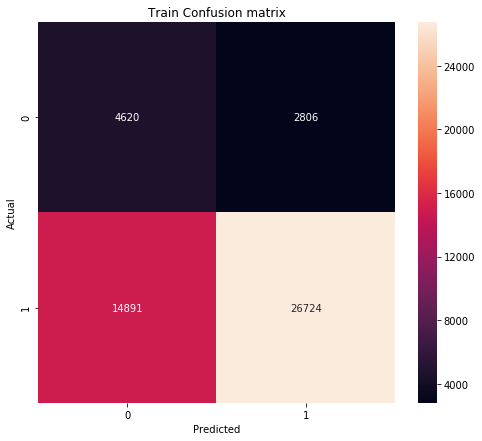

In [170]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

import seaborn as sn
df_cm=pd.DataFrame(cm,index=[0,1],columns=[0,1])
plt.figure(figsize = (8,7))
plt.title("Train Confusion matrix")
ax=sn.heatmap(df_cm, annot=True,fmt='g')
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#### Test Data

In [171]:
from sklearn.preprocessing import binarize
y_predict_thres=binarize(probs_test.reshape(-1,1),a)#changing the threshold and printing the first value
print(y_predict_thres[0])

[1.]


In [172]:
from sklearn.metrics import confusion_matrix
print("Threshold",a)

print("Test confusion matrix")
cm1=confusion_matrix(y_test, y_predict_thres)
print(cm1)

Threshold 0.8468953485855067
Test confusion matrix
[[ 3173  2286]
 [10574 20019]]


Text(0.5, 42.0, 'Predicted')

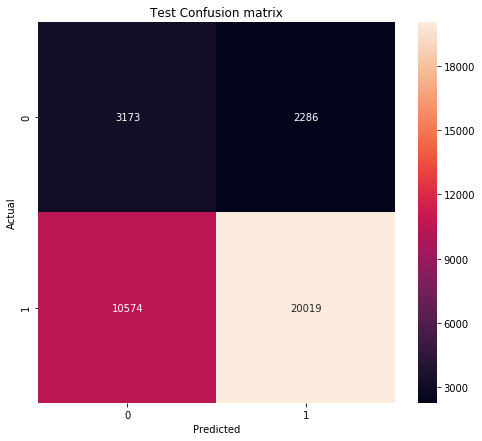

In [173]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

import seaborn as sn
df_cm=pd.DataFrame(cm1,index=[0,1],columns=[0,1])
plt.figure(figsize = (8,7))
plt.title("Test Confusion matrix")
ax=sn.heatmap(df_cm, annot=True,fmt='g')
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

## Set 2: Categorical Features,Numerical Features+Preprocessed Essay(tf-idf)+Preprocessed Title(tf-idf)

In [174]:
from scipy.sparse import hstack

X_tr=hstack((categories_ohe_train,subcategories_ohe_train,state_ohe_train,grade_ohe_train,prefix_ohe_train,price_train,quantity_train,tnp_train,train_tfidf_title,train_tfidf_essay)).tocsr()

X_cv=hstack((categories_ohe_cv,subcategories_ohe_cv,state_ohe_cv,grade_ohe_cv,prefix_ohe_cv,price_cv,quantity_cv,tnp_cv,cv_tfidf_essay,cv_tfidf_title)).tocsr()

X_te=hstack((categories_ohe_test,subcategories_ohe_test,state_ohe_test,grade_ohe_test,prefix_ohe_test,price_test,quantity_test,tnp_test,test_tfidf_essay,test_tfidf_title)).tocsr()

In [175]:
#checking the final matrix are of same dimension or not
print(X_tr.shape,y_train.shape)
print("="*50)
print(X_cv.shape,y_cv.shape)
print("="*50)
print(X_te.shape,y_test.shape)

(49041, 14128) (49041,)
(24155, 14128) (24155,)
(36052, 14128) (36052,)


### Using Brute Force for finding best Hyperparameter

#### Using L2 as a Regularization term

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

0.803417245194437
0.5335648571515397
corresponding alpha 0.0001


  4%|███▎                                                                               | 1/25 [00:00<00:13,  1.79it/s]

0.7911019758764266
0.5477690147538488
corresponding alpha 0.00017782794100389227


  8%|██████▋                                                                            | 2/25 [00:01<00:13,  1.72it/s]

0.78510134791758
0.5479445789451624
corresponding alpha 0.00031622776601683794


 12%|█████████▉                                                                         | 3/25 [00:01<00:12,  1.73it/s]

0.7631284074234275
0.5566129850186736
corresponding alpha 0.0005623413251903491


 16%|█████████████▎                                                                     | 4/25 [00:02<00:12,  1.69it/s]

0.7437531135429909
0.5572410633951282
corresponding alpha 0.001


 20%|████████████████▌                                                                  | 5/25 [00:02<00:11,  1.71it/s]

0.7023772089834162
0.566018859413457
corresponding alpha 0.0017782794100389228


 24%|███████████████████▉                                                               | 6/25 [00:03<00:11,  1.72it/s]

0.6688140317964111
0.5709436347498558
corresponding alpha 0.0031622776601683794


 28%|███████████████████████▏                                                           | 7/25 [00:04<00:10,  1.74it/s]

0.6312803497128252
0.5673746210472177
corresponding alpha 0.005623413251903491


 32%|██████████████████████████▌                                                        | 8/25 [00:04<00:09,  1.74it/s]

0.6020296053181895
0.5619649947907708
corresponding alpha 0.01


 36%|█████████████████████████████▉                                                     | 9/25 [00:05<00:09,  1.72it/s]

0.584093369772593
0.5596901641871035
corresponding alpha 0.01778279410038923


 40%|████████████████████████████████▊                                                 | 10/25 [00:05<00:08,  1.72it/s]

0.5718001968009953
0.5562225429570977
corresponding alpha 0.03162277660168379


 44%|████████████████████████████████████                                              | 11/25 [00:06<00:07,  1.75it/s]

0.5645473967035041
0.5536946413841425
corresponding alpha 0.05623413251903491


 48%|███████████████████████████████████████▎                                          | 12/25 [00:06<00:07,  1.76it/s]

0.562225052412689
0.5519007463409131
corresponding alpha 0.1


 52%|██████████████████████████████████████████▋                                       | 13/25 [00:07<00:06,  1.76it/s]

0.5617694683664679
0.5518711576948636
corresponding alpha 0.1778279410038923


 56%|█████████████████████████████████████████████▉                                    | 14/25 [00:08<00:06,  1.77it/s]

0.5617655577807404
0.551617886622018
corresponding alpha 0.31622776601683794


 60%|█████████████████████████████████████████████████▏                                | 15/25 [00:08<00:05,  1.73it/s]

0.5617850071605623
0.5519119521401382
corresponding alpha 0.5623413251903491


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:09<00:05,  1.71it/s]

0.5617937780688076
0.5518552761425093
corresponding alpha 1.0


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [00:09<00:04,  1.72it/s]

0.5617635515224443
0.5517341801395725
corresponding alpha 1.7782794100389228


 72%|███████████████████████████████████████████████████████████                       | 18/25 [00:10<00:04,  1.73it/s]

0.5617687613222135
0.5517341801395725
corresponding alpha 3.1622776601683795


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [00:10<00:03,  1.75it/s]

0.5618079383692984
0.5518423161020958
corresponding alpha 5.623413251903491


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [00:11<00:02,  1.73it/s]

0.5617809736106167
0.5517341801395725
corresponding alpha 10.0


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:12<00:02,  1.72it/s]

0.5617777457998901
0.5517341801395725
corresponding alpha 17.78279410038923


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [00:12<00:01,  1.70it/s]

0.5617778347871534
0.5517341801395725
corresponding alpha 31.622776601683793


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [00:13<00:01,  1.72it/s]

0.5617741021759521
0.5517341801395725
corresponding alpha 56.23413251903491


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [00:13<00:00,  1.75it/s]

0.5617107141214923
0.5517611807796103
corresponding alpha 100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.75it/s]


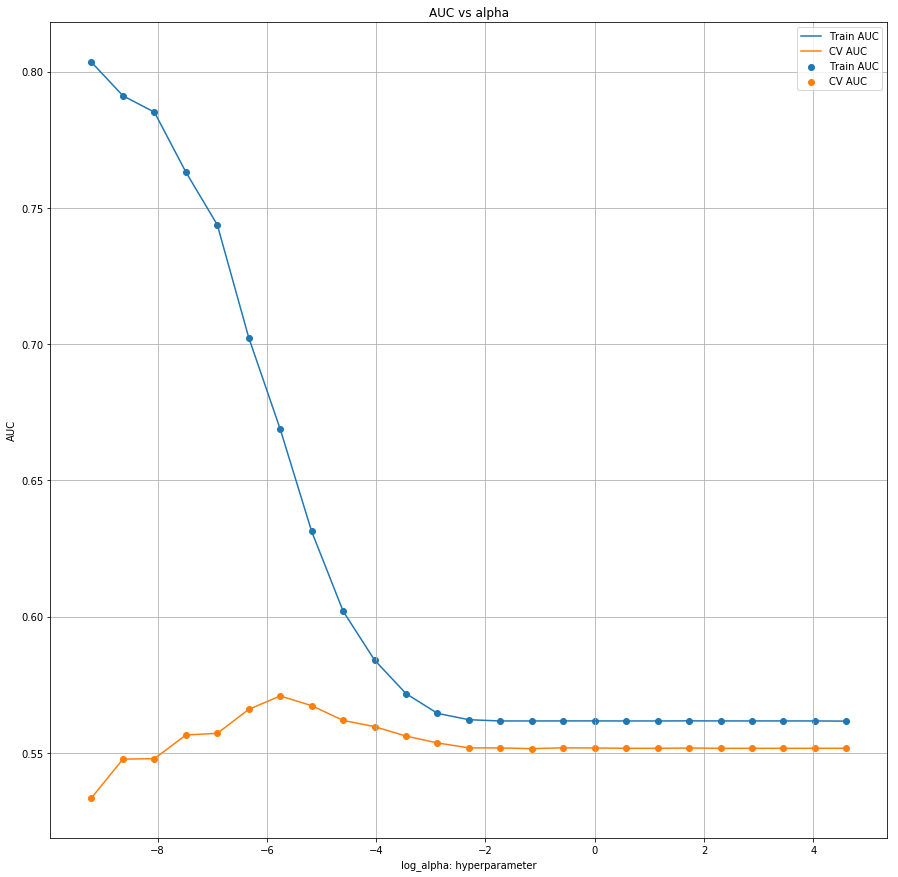

In [176]:
from sklearn.linear_model import SGDClassifier 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm

import math
alpha1=[]
train_auc = []
cv_auc = []
alpha=np.logspace(-4,2,25)
for i in tqdm(alpha):
    clf=SGDClassifier(loss='hinge',alpha=i,penalty='l2',class_weight='balanced')
    calibrated=CalibratedClassifierCV(clf ,method='isotonic',cv=3)
    calibrated.fit(X_tr,y_train)
    probs_train=calibrated.predict_proba(X_tr)[:,1]
    probs_cv=calibrated.predict_proba(X_cv)[:,1]
    train_auc.append(roc_auc_score(y_train,probs_train))#roc_auc_score->Compute(ROC AUC) from prediction scores.
    print(roc_auc_score(y_train,probs_train))
    cv_auc.append(roc_auc_score(y_cv, probs_cv))
    print(roc_auc_score(y_cv, probs_cv))
    print("corresponding alpha",i)

for i in alpha:
    j=math.log(i)
    alpha1.append(j)
    
plt.figure(figsize=(15,15))
plt.plot(alpha1, train_auc, label='Train AUC') #Plotting alpha vs auc of train
plt.scatter(alpha1, train_auc, label='Train AUC') #Scatter plot of alpha vs auc train

plt.plot(alpha1, cv_auc, label='CV AUC') #Plotting alpha vs auc of CV
plt.scatter(alpha1, cv_auc, label='CV AUC') #Scatter plot of alpha vs auc of CV

plt.legend() #adding legend
plt.xlabel("log_alpha: hyperparameter") #X axis-label
plt.ylabel("AUC")  #Y-axis label
plt.title("AUC vs alpha") #adding title of the plot
plt.grid()
plt.show()

#### Using L1 as a Regularization term

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

0.7704459271484252
0.5126055836416462
corresponding alpha 0.0001


  4%|███▎                                                                               | 1/25 [00:01<00:26,  1.11s/it]

0.7407422246408061
0.5203845160614188
corresponding alpha 0.00017782794100389227


  8%|██████▋                                                                            | 2/25 [00:02<00:24,  1.05s/it]

0.7163172045159321
0.545655007379419
corresponding alpha 0.00031622776601683794


 12%|█████████▉                                                                         | 3/25 [00:02<00:21,  1.02it/s]

0.6880253092072791
0.5576328728310141
corresponding alpha 0.0005623413251903491


 16%|█████████████▎                                                                     | 4/25 [00:03<00:19,  1.09it/s]

0.6521909214288093
0.5656856936601831
corresponding alpha 0.001


 20%|████████████████▌                                                                  | 5/25 [00:04<00:17,  1.15it/s]

0.6107526626849774
0.5589885811038261
corresponding alpha 0.0017782794100389228


 24%|███████████████████▉                                                               | 6/25 [00:05<00:15,  1.21it/s]

0.5753233093334145
0.5481234315049391
corresponding alpha 0.0031622776601683794


 28%|███████████████████████▏                                                           | 7/25 [00:05<00:14,  1.26it/s]

0.5467374664433076
0.5440373835600733
corresponding alpha 0.005623413251903491


 32%|██████████████████████████▌                                                        | 8/25 [00:06<00:13,  1.30it/s]

0.5382275740204954
0.5405595170279189
corresponding alpha 0.01


 36%|█████████████████████████████▉                                                     | 9/25 [00:07<00:11,  1.33it/s]

0.5292242100107176
0.5329339506448043
corresponding alpha 0.01778279410038923


 40%|████████████████████████████████▊                                                 | 10/25 [00:07<00:10,  1.36it/s]

0.5292242100107176
0.5329339506448043
corresponding alpha 0.03162277660168379


 44%|████████████████████████████████████                                              | 11/25 [00:08<00:10,  1.39it/s]

0.5
0.5
corresponding alpha 0.05623413251903491


 48%|███████████████████████████████████████▎                                          | 12/25 [00:09<00:09,  1.39it/s]

0.5
0.5
corresponding alpha 0.1


 52%|██████████████████████████████████████████▋                                       | 13/25 [00:10<00:08,  1.42it/s]

0.5
0.5
corresponding alpha 0.1778279410038923


 56%|█████████████████████████████████████████████▉                                    | 14/25 [00:10<00:07,  1.43it/s]

0.5
0.5
corresponding alpha 0.31622776601683794


 60%|█████████████████████████████████████████████████▏                                | 15/25 [00:11<00:07,  1.43it/s]

0.5
0.5
corresponding alpha 0.5623413251903491


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:12<00:06,  1.45it/s]

0.5
0.5
corresponding alpha 1.0


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [00:12<00:05,  1.44it/s]

0.5
0.5
corresponding alpha 1.7782794100389228


 72%|███████████████████████████████████████████████████████████                       | 18/25 [00:13<00:04,  1.44it/s]

0.5
0.5
corresponding alpha 3.1622776601683795


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [00:14<00:04,  1.43it/s]

0.5
0.5
corresponding alpha 5.623413251903491


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [00:14<00:03,  1.40it/s]

0.5
0.5
corresponding alpha 10.0


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:15<00:02,  1.39it/s]

0.5
0.5
corresponding alpha 17.78279410038923


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [00:16<00:02,  1.40it/s]

0.5
0.5
corresponding alpha 31.622776601683793


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [00:17<00:01,  1.40it/s]

0.5
0.5
corresponding alpha 56.23413251903491


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [00:17<00:00,  1.39it/s]

0.5
0.5
corresponding alpha 100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:18<00:00,  1.39it/s]


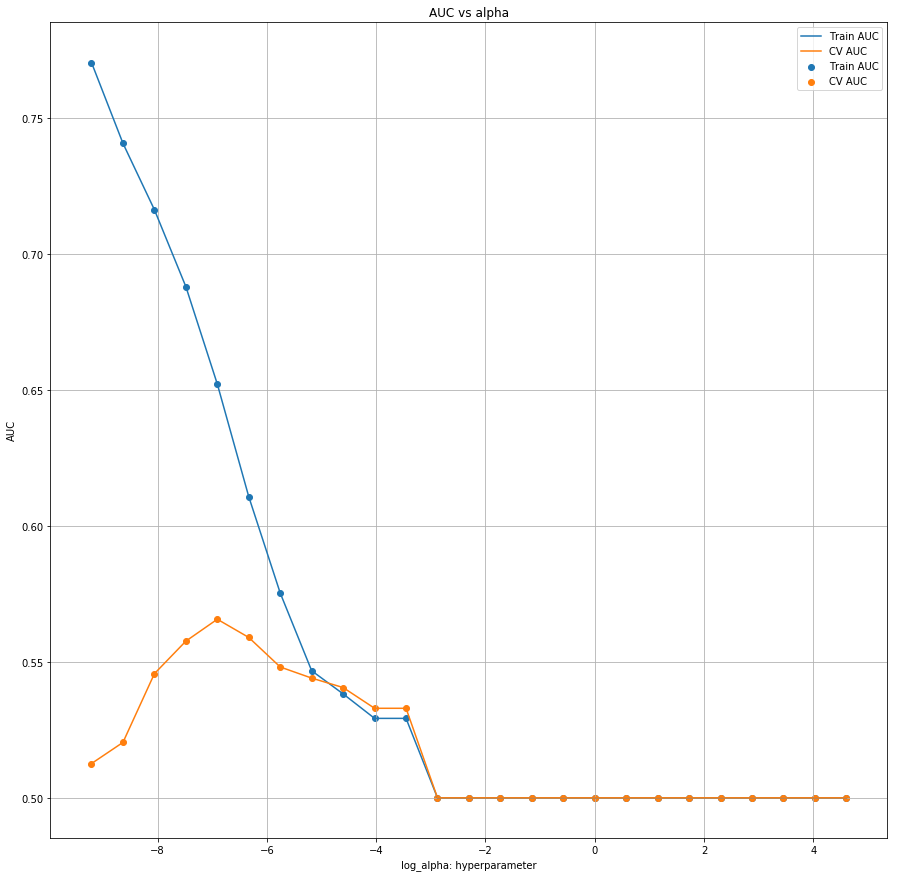

In [177]:
from sklearn.linear_model import SGDClassifier 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import math
alpha1=[]
train_auc = []
cv_auc = []
alpha=np.logspace(-4,2,25)
for i in tqdm(alpha):
    clf=SGDClassifier(loss='hinge',alpha=i,penalty='l1',class_weight='balanced')
    calibrated=CalibratedClassifierCV(clf ,method='isotonic',cv=3)
    calibrated.fit(X_tr,y_train)
    probs_train=calibrated.predict_proba(X_tr)[:,1]
    probs_cv=calibrated.predict_proba(X_cv)[:,1]
    train_auc.append(roc_auc_score(y_train,probs_train))#roc_auc_score->Compute(ROC AUC) from prediction scores.
    print(roc_auc_score(y_train,probs_train))
    cv_auc.append(roc_auc_score(y_cv, probs_cv))
    print(roc_auc_score(y_cv, probs_cv))
    print("corresponding alpha",i)

for i in alpha:
    j=math.log(i)
    alpha1.append(j)
    
plt.figure(figsize=(15,15))
plt.plot(alpha1, train_auc, label='Train AUC') #Plotting alpha vs auc of train
plt.scatter(alpha1, train_auc, label='Train AUC') #Scatter plot of alpha vs auc train

plt.plot(alpha1, cv_auc, label='CV AUC') #Plotting alpha vs auc of CV
plt.scatter(alpha1, cv_auc, label='CV AUC') #Scatter plot of alpha vs auc of CV

plt.legend() #adding legend
plt.xlabel("log_alpha: hyperparameter") #X axis-label
plt.ylabel("AUC")  #Y-axis label
plt.title("AUC vs alpha") #adding title of the plot
plt.grid()
plt.show()

#### L2 regularization is performing better than L1

### Testing on Test Data(using our best hyper parameter=0.0005623413251903491

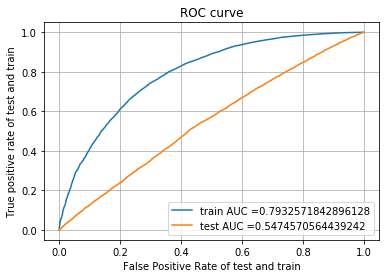

In [179]:
from sklearn.metrics import roc_curve,auc

clf=SGDClassifier(alpha=0.0031622776601683794 , penalty='l2')
calibrated=CalibratedClassifierCV(clf ,method='isotonic',cv=3)
calibrated.fit(X_tr,y_train)

#documentation of roc_curve ->https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
#roc_curve returns three values fpr,tpr and thresholds
probs_train=calibrated.predict_proba(X_tr)[:,1]
probs_test=calibrated.predict_proba(X_te)[:,1]
train_fpr,train_tpr,train_thresholds= roc_curve(y_train,probs_train)
test_fpr,test_tpr,test_thresholds= roc_curve(y_test,probs_test)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr))) #documentation of auc-> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("False Positive Rate of test and train") #plt.plot documentation ->https://matplotlib.org/3.1.0/tutorials/introductory/pyplot.html
plt.ylabel("True positive rate of test and train")
plt.title("ROC curve")
plt.grid()
plt.show()

### Confusion Matrix

In [180]:

df=pd.DataFrame({"fpr":train_fpr,"tpr":train_tpr,"threshold":train_thresholds})
print(df.head(3))
print(df.shape)

   fpr       tpr  threshold
0  0.0  0.000000   2.000000
1  0.0  0.000168   1.000000
2  0.0  0.000216   0.990853
(6485, 3)


In [181]:
df['Specificty']=1-df.fpr


In [182]:
df['Value']=df.tpr*df.Specificty

In [183]:
df.sort_values("Value", axis = 0, ascending = False, 
                 inplace = True, na_position ='first') 

In [184]:
index = df.Value.argmax()

In [185]:
a=df['threshold'][index]
print(a)


0.8305654886298551


In [186]:
from sklearn.preprocessing import binarize
y_predict_thres=binarize(probs_train.reshape(-1,1),a)#changing the threshold and printing the first value
print(y_predict_thres[0])

[1.]


In [187]:
from sklearn.metrics import confusion_matrix
print("Threshold",a)
print("confusion matrix")
cm=confusion_matrix(y_train, y_predict_thres)
print(cm)


Threshold 0.8305654886298551
confusion matrix
[[ 5222  2204]
 [10777 30838]]


Text(0.5, 42.0, 'Predicted')

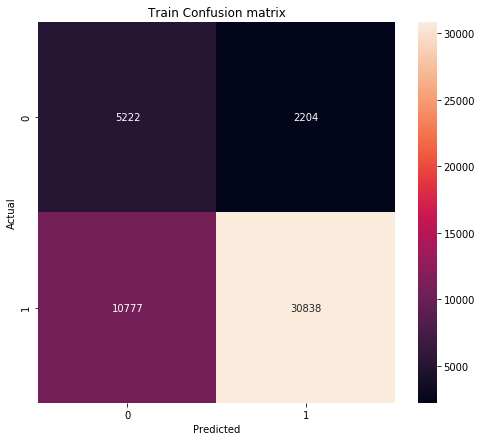

In [188]:

#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

import seaborn as sn
df_cm=pd.DataFrame(cm,index=[0,1],columns=[0,1])
plt.figure(figsize = (8,7))
plt.title("Train Confusion matrix")
ax=sn.heatmap(df_cm, annot=True,fmt='g')
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#### Test Data

In [189]:
from sklearn.preprocessing import binarize
y_predict_thres=binarize(probs_test.reshape(-1,1),a)#changing the threshold and printing the first value
print(y_predict_thres[0])

[1.]


In [190]:
from sklearn.metrics import confusion_matrix
print("Threshold",a)

print("Test confusion matrix")
cm1=confusion_matrix(y_test, y_predict_thres)
print(cm1)

Threshold 0.8305654886298551
Test confusion matrix
[[ 4617   842]
 [24866  5727]]


Text(0.5, 42.0, 'Predicted')

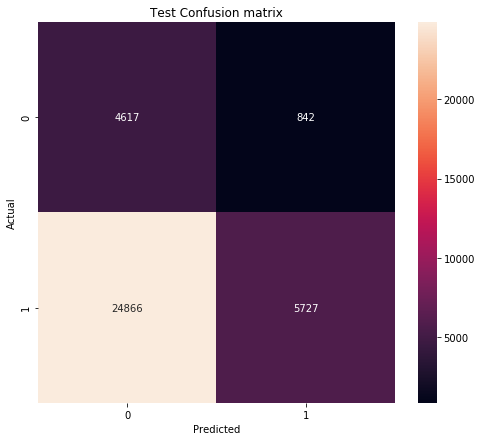

In [191]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

import seaborn as sn
df_cm=pd.DataFrame(cm1,index=[0,1],columns=[0,1])
plt.figure(figsize = (8,7))
plt.title("Test Confusion matrix")
ax=sn.heatmap(df_cm, annot=True,fmt='g')
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

## Set 3: Categorical Features,Numerical Features+Preprocessed Essay(Avg W2V)+Preprocessed Title(Avg W2V)

In [192]:
X_tr=hstack((categories_ohe_train,subcategories_ohe_train,state_ohe_train,grade_ohe_train,prefix_ohe_train,price_train,quantity_train,tnp_train,avg_w2v_vectors_train,avg_w2v_vectors_title_train)).tocsr()

X_cv=hstack((categories_ohe_cv,subcategories_ohe_cv,state_ohe_cv,grade_ohe_cv,prefix_ohe_cv,price_cv,quantity_cv,tnp_cv,avg_w2v_vectors_cv,avg_w2v_vectors_title_cv)).tocsr()

X_te=hstack((categories_ohe_test,subcategories_ohe_test,state_ohe_test,grade_ohe_test,prefix_ohe_test,price_test,quantity_test,tnp_test,avg_w2v_vectors_test,avg_w2v_vectors_title_test)).tocsr()

In [193]:
#checking the final matrix are of same dimension or not
print(X_tr.shape,y_train.shape)
print("="*50)
print(X_cv.shape,y_cv.shape)
print("="*50)
print(X_te.shape,y_test.shape)

(49041, 703) (49041,)
(24155, 703) (24155,)
(36052, 703) (36052,)


### Using Brute Force for finding best Hyperparameter

#### Using L2 as a Regularization term

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

0.7027499491235548
0.6749921285930561
corresponding alpha 0.0001


  4%|███▎                                                                               | 1/25 [00:02<00:55,  2.29s/it]

0.7037700117388762
0.6777725741959311
corresponding alpha 0.00017782794100389227


  8%|██████▋                                                                            | 2/25 [00:04<00:52,  2.28s/it]

0.6989852701486661
0.6715272221013152
corresponding alpha 0.00031622776601683794


 12%|█████████▉                                                                         | 3/25 [00:06<00:50,  2.28s/it]

0.7042193699125779
0.6816667294991837
corresponding alpha 0.0005623413251903491


 16%|█████████████▎                                                                     | 4/25 [00:08<00:47,  2.24s/it]

0.7048039757826501
0.68430622215609
corresponding alpha 0.001


 20%|████████████████▌                                                                  | 5/25 [00:11<00:44,  2.22s/it]

0.7047476339014809
0.683714282482137
corresponding alpha 0.0017782794100389228


 24%|███████████████████▉                                                               | 6/25 [00:13<00:42,  2.21s/it]

0.6968161069146696
0.679067304244626
corresponding alpha 0.0031622776601683794


 28%|███████████████████████▏                                                           | 7/25 [00:15<00:39,  2.22s/it]

0.690095361663491
0.6737503592859377
corresponding alpha 0.005623413251903491


 32%|██████████████████████████▌                                                        | 8/25 [00:17<00:37,  2.22s/it]

0.6757573519901549
0.6648102259214522
corresponding alpha 0.01


 36%|█████████████████████████████▉                                                     | 9/25 [00:20<00:35,  2.23s/it]

0.6617440099194587
0.6541128164647768
corresponding alpha 0.01778279410038923


 40%|████████████████████████████████▊                                                 | 10/25 [00:22<00:33,  2.23s/it]

0.6453053539688433
0.641487002353458
corresponding alpha 0.03162277660168379


 44%|████████████████████████████████████                                              | 11/25 [00:24<00:31,  2.24s/it]

0.6280144637632377
0.6277370331360552
corresponding alpha 0.05623413251903491


 48%|███████████████████████████████████████▎                                          | 12/25 [00:26<00:29,  2.24s/it]

0.6144215363544197
0.6161249769980961
corresponding alpha 0.1


 52%|██████████████████████████████████████████▋                                       | 13/25 [00:29<00:27,  2.25s/it]

0.6064551182707063
0.6088764057174869
corresponding alpha 0.1778279410038923


 56%|█████████████████████████████████████████████▉                                    | 14/25 [00:31<00:24,  2.24s/it]

0.6038385125160909
0.6057597327769066
corresponding alpha 0.31622776601683794


 60%|█████████████████████████████████████████████████▏                                | 15/25 [00:33<00:22,  2.26s/it]

0.6019868849600815
0.602898898904828
corresponding alpha 0.5623413251903491


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:35<00:20,  2.26s/it]

0.6018946504708123
0.6027489279585304
corresponding alpha 1.0


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [00:38<00:18,  2.26s/it]

0.6020432883233598
0.6027149903951626
corresponding alpha 1.7782794100389228


 72%|███████████████████████████████████████████████████████████                       | 18/25 [00:40<00:15,  2.26s/it]

0.601799422773601
0.6025009663000795
corresponding alpha 3.1622776601683795


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [00:42<00:13,  2.27s/it]

0.6017739093162837
0.6025465965813295
corresponding alpha 5.623413251903491


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [00:44<00:11,  2.26s/it]

0.6018940615369253
0.6025085635651497
corresponding alpha 10.0


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:47<00:09,  2.26s/it]

0.6018976388249034
0.6024830637017936
corresponding alpha 17.78279410038923


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [00:49<00:06,  2.26s/it]

0.6019199681561506
0.6024465981634816
corresponding alpha 31.622776601683793


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [00:51<00:04,  2.26s/it]

0.6017926290005478
0.6024054168513289
corresponding alpha 56.23413251903491


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [00:53<00:02,  2.26s/it]

0.6019180298517643
0.6024567167333772
corresponding alpha 100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:56<00:00,  2.27s/it]


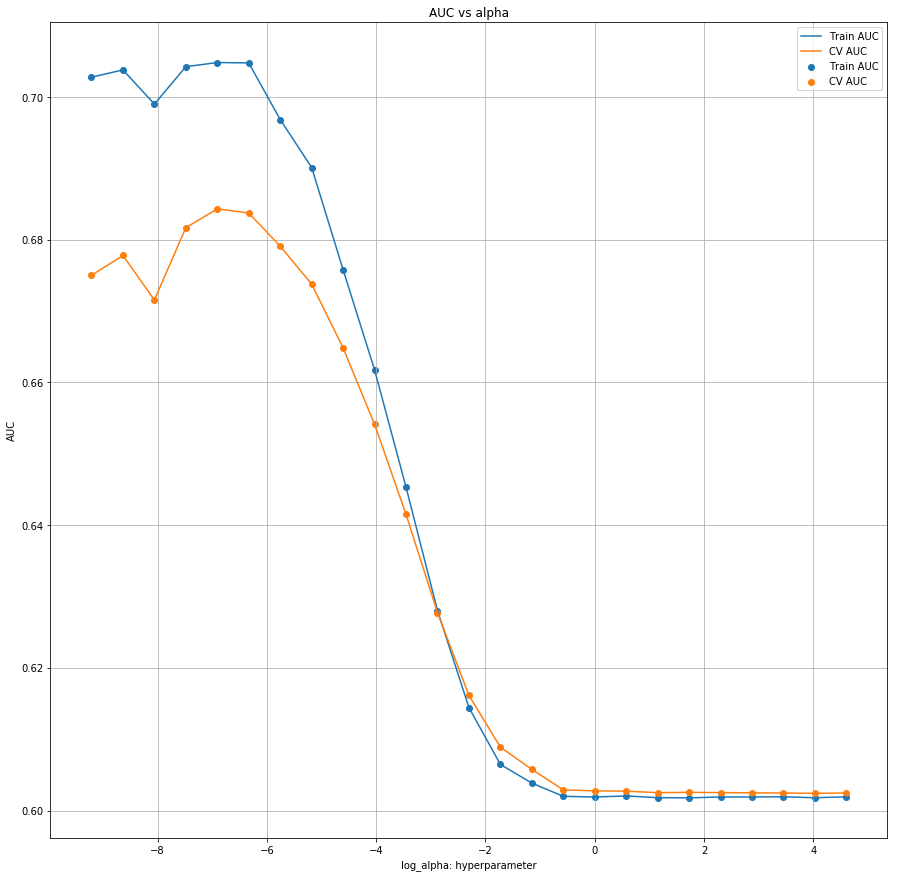

In [194]:
from sklearn.linear_model import SGDClassifier 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import math
alpha1=[]
train_auc = []
cv_auc = []
alpha=np.logspace(-4,2,25)
for i in tqdm(alpha):
    clf=SGDClassifier(loss='hinge',alpha=i,penalty='l2',class_weight='balanced')
    calibrated=CalibratedClassifierCV(clf ,method='isotonic',cv=3)
    calibrated.fit(X_tr,y_train)
    probs_train=calibrated.predict_proba(X_tr)[:,1]
    probs_cv=calibrated.predict_proba(X_cv)[:,1]
    train_auc.append(roc_auc_score(y_train,probs_train))#roc_auc_score->Compute(ROC AUC) from prediction scores.
    print(roc_auc_score(y_train,probs_train))
    cv_auc.append(roc_auc_score(y_cv, probs_cv))
    print(roc_auc_score(y_cv, probs_cv))
    print("corresponding alpha",i)

for i in alpha:
    j=math.log(i)
    alpha1.append(j)
    
plt.figure(figsize=(15,15))
plt.plot(alpha1, train_auc, label='Train AUC') #Plotting alpha vs auc of train
plt.scatter(alpha1, train_auc, label='Train AUC') #Scatter plot of alpha vs auc train

plt.plot(alpha1, cv_auc, label='CV AUC') #Plotting alpha vs auc of CV
plt.scatter(alpha1, cv_auc, label='CV AUC') #Scatter plot of alpha vs auc of CV

plt.legend() #adding legend
plt.xlabel("log_alpha: hyperparameter") #X axis-label
plt.ylabel("AUC")  #Y-axis label
plt.title("AUC vs alpha") #adding title of the plot
plt.grid()
plt.show()

#### Using L1 as a Regularization term

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

0.7179329511066117
0.6915709818145086
corresponding alpha 0.0001


  4%|███▎                                                                               | 1/25 [00:03<01:26,  3.61s/it]

0.7112036792576739
0.6866079199974238
corresponding alpha 0.00017782794100389227


  8%|██████▋                                                                            | 2/25 [00:07<01:23,  3.62s/it]

0.7101624684147799
0.6914026947225728
corresponding alpha 0.00031622776601683794


 12%|█████████▉                                                                         | 3/25 [00:11<01:20,  3.66s/it]

0.7011559720533398
0.6893071635766275
corresponding alpha 0.0005623413251903491


 16%|█████████████▎                                                                     | 4/25 [00:14<01:18,  3.74s/it]

0.6877764797861872
0.6782688110084064
corresponding alpha 0.001


 20%|████████████████▌                                                                  | 5/25 [00:18<01:15,  3.80s/it]

0.6679781776696397
0.6621176324504792
corresponding alpha 0.0017782794100389228


 24%|███████████████████▉                                                               | 6/25 [00:22<01:12,  3.84s/it]

0.6344536436061406
0.6326277375067145
corresponding alpha 0.0031622776601683794


 28%|███████████████████████▏                                                           | 7/25 [00:26<01:09,  3.87s/it]

0.6002841929594637
0.5995420616744245
corresponding alpha 0.005623413251903491


 32%|██████████████████████████▌                                                        | 8/25 [00:30<01:06,  3.89s/it]

0.5694913834280282
0.570310120226753
corresponding alpha 0.01


 36%|█████████████████████████████▉                                                     | 9/25 [00:34<01:02,  3.91s/it]

0.5550570005487117
0.5561798608682632
corresponding alpha 0.01778279410038923


 40%|████████████████████████████████▊                                                 | 10/25 [00:38<00:58,  3.93s/it]

0.5393442881292383
0.53728849087313
corresponding alpha 0.03162277660168379


 44%|████████████████████████████████████                                              | 11/25 [00:42<00:55,  3.94s/it]

0.5
0.5
corresponding alpha 0.05623413251903491


 48%|███████████████████████████████████████▎                                          | 12/25 [00:46<00:51,  3.95s/it]

0.5
0.5
corresponding alpha 0.1


 52%|██████████████████████████████████████████▋                                       | 13/25 [00:50<00:47,  3.96s/it]

0.5
0.5
corresponding alpha 0.1778279410038923


 56%|█████████████████████████████████████████████▉                                    | 14/25 [00:54<00:43,  3.96s/it]

0.5
0.5
corresponding alpha 0.31622776601683794


 60%|█████████████████████████████████████████████████▏                                | 15/25 [00:58<00:39,  3.96s/it]

0.5
0.5
corresponding alpha 0.5623413251903491


 64%|████████████████████████████████████████████████████▍                             | 16/25 [01:02<00:35,  3.96s/it]

0.5
0.5
corresponding alpha 1.0


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [01:06<00:31,  3.97s/it]

0.5
0.5
corresponding alpha 1.7782794100389228


 72%|███████████████████████████████████████████████████████████                       | 18/25 [01:10<00:27,  3.97s/it]

0.5
0.5
corresponding alpha 3.1622776601683795


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [01:14<00:23,  3.97s/it]

0.5
0.5
corresponding alpha 5.623413251903491


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [01:18<00:19,  3.97s/it]

0.5
0.5
corresponding alpha 10.0


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [01:22<00:15,  3.98s/it]

0.5
0.5
corresponding alpha 17.78279410038923


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [01:26<00:11,  3.98s/it]

0.5
0.5
corresponding alpha 31.622776601683793


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [01:30<00:07,  3.98s/it]

0.5
0.5
corresponding alpha 56.23413251903491


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [01:34<00:03,  3.98s/it]

0.5
0.5
corresponding alpha 100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:38<00:00,  3.98s/it]


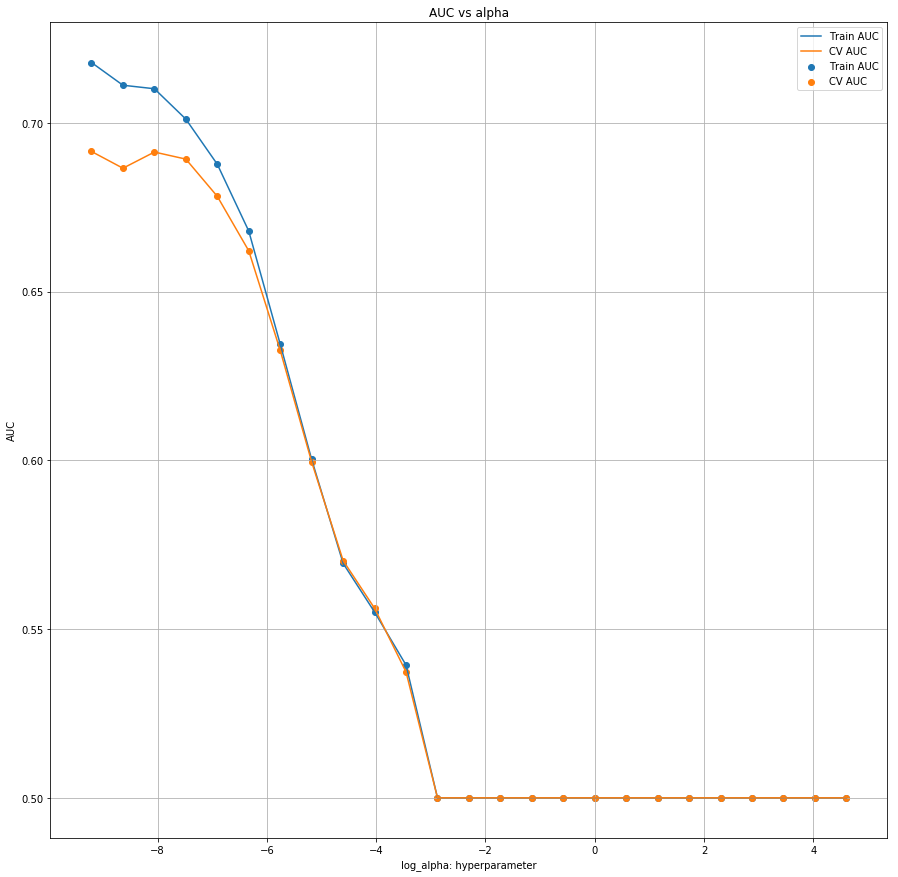

In [195]:
from sklearn.linear_model import SGDClassifier 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import math
alpha1=[]
train_auc = []
cv_auc = []
alpha=np.logspace(-4,2,25)
for i in tqdm(alpha):
    clf=SGDClassifier(loss='hinge',alpha=i,penalty='l1',class_weight='balanced')
    calibrated=CalibratedClassifierCV(clf ,method='isotonic',cv=3)
    calibrated.fit(X_tr,y_train)
    probs_train=calibrated.predict_proba(X_tr)[:,1]
    probs_cv=calibrated.predict_proba(X_cv)[:,1]
    train_auc.append(roc_auc_score(y_train,probs_train))#roc_auc_score->Compute(ROC AUC) from prediction scores.
    print(roc_auc_score(y_train,probs_train))
    cv_auc.append(roc_auc_score(y_cv, probs_cv))
    print(roc_auc_score(y_cv, probs_cv))
    print("corresponding alpha",i)

for i in alpha:
    j=math.log(i)
    alpha1.append(j)
    
plt.figure(figsize=(15,15))
plt.plot(alpha1, train_auc, label='Train AUC') #Plotting alpha vs auc of train
plt.scatter(alpha1, train_auc, label='Train AUC') #Scatter plot of alpha vs auc train

plt.plot(alpha1, cv_auc, label='CV AUC') #Plotting alpha vs auc of CV
plt.scatter(alpha1, cv_auc, label='CV AUC') #Scatter plot of alpha vs auc of CV

plt.legend() #adding legend
plt.xlabel("log_alpha: hyperparameter") #X axis-label
plt.ylabel("AUC")  #Y-axis label
plt.title("AUC vs alpha") #adding title of the plot
plt.grid()
plt.show()

#### L1 regularization is performing better than L2

### Testing on Test Data(using our best hyper parameter= 0.00017782794100389227)

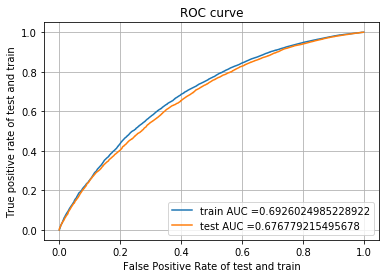

In [196]:
from sklearn.metrics import roc_curve,auc

clf=SGDClassifier(alpha= 0.00017782794100389227 , penalty='l1')
calibrated=CalibratedClassifierCV(clf ,method='isotonic',cv=3)
calibrated.fit(X_tr,y_train)

#documentation of roc_curve ->https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
#roc_curve returns three values fpr,tpr and thresholds
probs_train=calibrated.predict_proba(X_tr)[:,1]
probs_test=calibrated.predict_proba(X_te)[:,1]
train_fpr,train_tpr,train_thresholds= roc_curve(y_train,probs_train)
test_fpr,test_tpr,test_thresholds= roc_curve(y_test,probs_test)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr))) #documentation of auc-> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("False Positive Rate of test and train") #plt.plot documentation ->https://matplotlib.org/3.1.0/tutorials/introductory/pyplot.html
plt.ylabel("True positive rate of test and train")
plt.title("ROC curve")
plt.grid()
plt.show()

### Confusion Matrix

In [197]:
df=pd.DataFrame({"fpr":train_fpr,"tpr":train_tpr,"threshold":train_thresholds})
print(df.head(3))
print(df.shape)


   fpr       tpr  threshold
0  0.0  0.000000   1.977651
1  0.0  0.000024   0.977651
2  0.0  0.000048   0.963763
(5273, 3)


In [198]:

df['Specificty']=1-df.fpr

In [199]:
df['Value']=df.tpr*df.Specificty

In [200]:
df.sort_values("Value", axis = 0, ascending = False, 
                 inplace = True, na_position ='first')

In [201]:
index = df.Value.argmax()

In [202]:
a=df['threshold'][index]
print(a)

0.8394888802869319


In [203]:
from sklearn.preprocessing import binarize
y_predict_thres=binarize(probs_train.reshape(-1,1),a)#changing the threshold and printing the first value
print(y_predict_thres[0])

[1.]


In [204]:
from sklearn.metrics import confusion_matrix
print("Threshold",a)
print("confusion matrix")
cm=confusion_matrix(y_train, y_predict_thres)
print(cm)

Threshold 0.8394888802869319
confusion matrix
[[ 4581  2845]
 [13811 27804]]


Text(0.5, 42.0, 'Predicted')

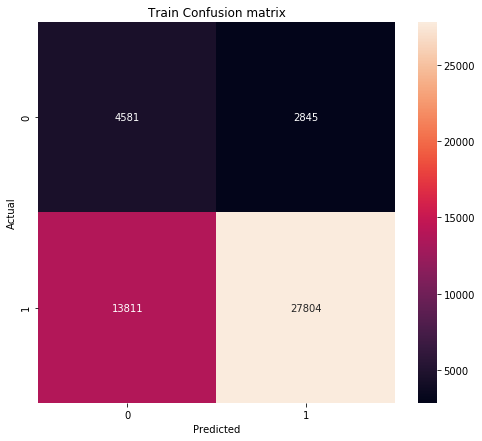

In [205]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

import seaborn as sn
df_cm=pd.DataFrame(cm,index=[0,1],columns=[0,1])
plt.figure(figsize = (8,7))
plt.title("Train Confusion matrix")
ax=sn.heatmap(df_cm, annot=True,fmt='g')
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#### Test Data

In [206]:
from sklearn.preprocessing import binarize
y_predict_thres=binarize(probs_test.reshape(-1,1),a)#changing the threshold and printing the first value
print(y_predict_thres[0])

[1.]


In [207]:
from sklearn.metrics import confusion_matrix
print("Threshold",a)

print("Test confusion matrix")
cm1=confusion_matrix(y_test, y_predict_thres)
print(cm1)

Threshold 0.8394888802869319
Test confusion matrix
[[ 3199  2260]
 [10104 20489]]


Text(0.5, 42.0, 'Predicted')

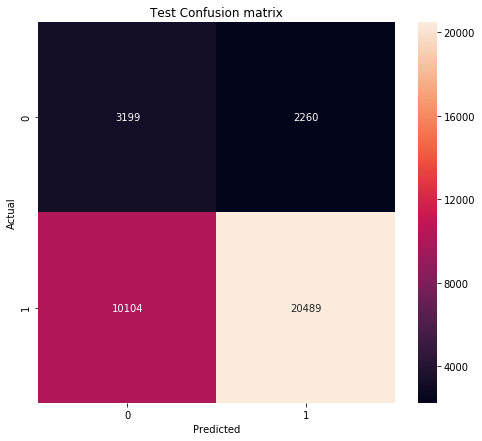

In [208]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

import seaborn as sn
df_cm=pd.DataFrame(cm1,index=[0,1],columns=[0,1])
plt.figure(figsize = (8,7))
plt.title("Test Confusion matrix")
ax=sn.heatmap(df_cm, annot=True,fmt='g')
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

## Set 4: Categorical Features,Numerical Features+Preprocessed Essay(TFIDF-W2V)+Preprocessed Title(TFIDF- W2V)

In [209]:
X_tr=hstack((categories_ohe_train,subcategories_ohe_train,state_ohe_train,grade_ohe_train,prefix_ohe_train,price_train,quantity_train,tnp_train,tfidf_w2v_vectors_train,tfidf_w2v_vectors_title_train)).tocsr()

X_cv=hstack((categories_ohe_cv,subcategories_ohe_cv,state_ohe_cv,grade_ohe_cv,prefix_ohe_cv,price_cv,quantity_cv,tnp_cv,tfidf_w2v_vectors_cv,tfidf_w2v_vectors_title_cv)).tocsr()

X_te=hstack((categories_ohe_test,subcategories_ohe_test,state_ohe_test,grade_ohe_test,prefix_ohe_test,price_test,quantity_test,tnp_test,tfidf_w2v_vectors_test,tfidf_w2v_vectors_title_test)).tocsr()

In [210]:
#checking the final matrix are of same dimension or not
print(X_tr.shape,y_train.shape)
print("="*50)
print(X_cv.shape,y_cv.shape)
print("="*50)
print(X_te.shape,y_test.shape)

(49041, 703) (49041,)
(24155, 703) (24155,)
(36052, 703) (36052,)


### Using Brute Force for finding best Hyperparameter

#### Using L2 as a Regularization term

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

0.6952599785543931
0.6662641850410425
corresponding alpha 0.0001


  4%|███▎                                                                               | 1/25 [00:02<00:52,  2.20s/it]

0.6979958984314264
0.6673864525035663
corresponding alpha 0.00017782794100389227


  8%|██████▋                                                                            | 2/25 [00:04<00:50,  2.19s/it]

0.7077699730375064
0.6764252102414708
corresponding alpha 0.00031622776601683794


 12%|█████████▉                                                                         | 3/25 [00:06<00:48,  2.20s/it]

0.7107804590700818
0.6849335267987888
corresponding alpha 0.0005623413251903491


 16%|█████████████▎                                                                     | 4/25 [00:08<00:46,  2.21s/it]

0.7115089136599947
0.6841922831903967
corresponding alpha 0.001


 20%|████████████████▌                                                                  | 5/25 [00:11<00:44,  2.22s/it]

0.713891303320076
0.6908607542575433
corresponding alpha 0.0017782794100389228


 24%|███████████████████▉                                                               | 6/25 [00:13<00:42,  2.24s/it]

0.710897750754701
0.6878128702499451
corresponding alpha 0.0031622776601683794


 28%|███████████████████████▏                                                           | 7/25 [00:15<00:40,  2.25s/it]

0.7047097868094925
0.6868469503670873
corresponding alpha 0.005623413251903491


 32%|██████████████████████████▌                                                        | 8/25 [00:17<00:38,  2.27s/it]

0.6980025773300126
0.6848296797225166
corresponding alpha 0.01


 36%|█████████████████████████████▉                                                     | 9/25 [00:20<00:36,  2.28s/it]

0.6869921800258283
0.6767266262302735
corresponding alpha 0.01778279410038923


 40%|████████████████████████████████▊                                                 | 10/25 [00:22<00:35,  2.34s/it]

0.6728894979788405
0.6670803474213975
corresponding alpha 0.03162277660168379


 44%|████████████████████████████████████                                              | 11/25 [00:25<00:32,  2.35s/it]

0.6572794428840754
0.6550116082741807
corresponding alpha 0.05623413251903491


 48%|███████████████████████████████████████▎                                          | 12/25 [00:27<00:30,  2.34s/it]

0.6399057492211431
0.6417920535568902
corresponding alpha 0.1


 52%|██████████████████████████████████████████▋                                       | 13/25 [00:29<00:28,  2.35s/it]

0.6276361077178201
0.6311063368180967
corresponding alpha 0.1778279410038923


 56%|█████████████████████████████████████████████▉                                    | 14/25 [00:32<00:25,  2.34s/it]

0.6226856718436437
0.6273215647895432
corresponding alpha 0.31622776601683794


 60%|█████████████████████████████████████████████████▏                                | 15/25 [00:34<00:24,  2.44s/it]

0.6196019250242506
0.6236733300884542
corresponding alpha 0.5623413251903491


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:37<00:21,  2.42s/it]

0.6196357903407012
0.6233944724407109
corresponding alpha 1.0


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [00:39<00:19,  2.40s/it]

0.6198320832995856
0.6235705835817485
corresponding alpha 1.7782794100389228


 72%|███████████████████████████████████████████████████████████                       | 18/25 [00:41<00:16,  2.37s/it]

0.6195668462451209
0.6236372847676129
corresponding alpha 3.1622776601683795


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [00:44<00:14,  2.37s/it]

0.6195809094685976
0.6235734850833337
corresponding alpha 5.623413251903491


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [00:46<00:11,  2.37s/it]

0.6196052952145983
0.6235850710793184
corresponding alpha 10.0


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:48<00:09,  2.35s/it]

0.6196002698611562
0.6235621325414995
corresponding alpha 17.78279410038923


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [00:51<00:07,  2.35s/it]

0.6195754440326905
0.6235651140845077
corresponding alpha 31.622776601683793


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [00:53<00:04,  2.35s/it]

0.6195421498526743
0.6235812090806567
corresponding alpha 56.23413251903491


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [00:55<00:02,  2.36s/it]

0.6195754407967901
0.6235622192530412
corresponding alpha 100.0


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:58<00:00,  2.39s/it]


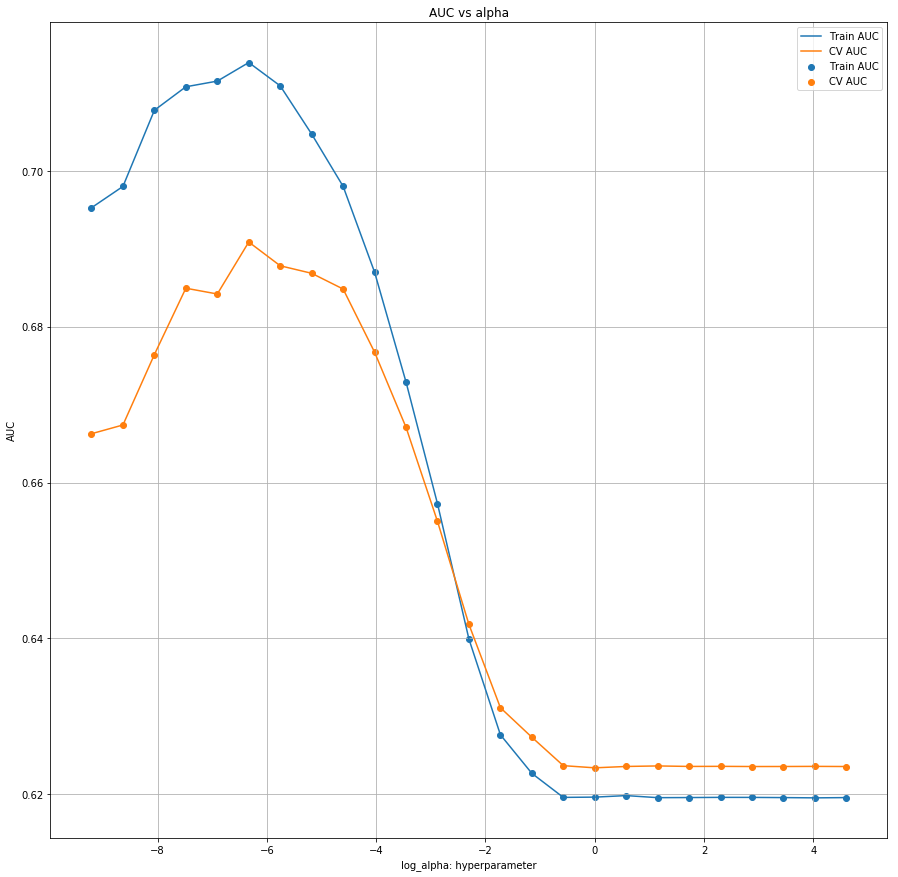

In [211]:
from sklearn.linear_model import SGDClassifier 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import math
alpha1=[]
train_auc = []
cv_auc = []
alpha=np.logspace(-4,2,25)
for i in tqdm(alpha):
    clf=SGDClassifier(loss='hinge',alpha=i,penalty='l2',class_weight='balanced')
    calibrated=CalibratedClassifierCV(clf ,method='isotonic',cv=3)
    calibrated.fit(X_tr,y_train)
    probs_train=calibrated.predict_proba(X_tr)[:,1]
    probs_cv=calibrated.predict_proba(X_cv)[:,1]
    train_auc.append(roc_auc_score(y_train,probs_train))#roc_auc_score->Compute(ROC AUC) from prediction scores.
    print(roc_auc_score(y_train,probs_train))
    cv_auc.append(roc_auc_score(y_cv, probs_cv))
    print(roc_auc_score(y_cv, probs_cv))
    print("corresponding alpha",i)

for i in alpha:
    j=math.log(i)
    alpha1.append(j)
    
plt.figure(figsize=(15,15))
plt.plot(alpha1, train_auc, label='Train AUC') #Plotting alpha vs auc of train
plt.scatter(alpha1, train_auc, label='Train AUC') #Scatter plot of alpha vs auc train

plt.plot(alpha1, cv_auc, label='CV AUC') #Plotting alpha vs auc of CV
plt.scatter(alpha1, cv_auc, label='CV AUC') #Scatter plot of alpha vs auc of CV

plt.legend() #adding legend
plt.xlabel("log_alpha: hyperparameter") #X axis-label
plt.ylabel("AUC")  #Y-axis label
plt.title("AUC vs alpha") #adding title of the plot
plt.grid()
plt.show()

#### Using L1 as a Regularization term


  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

0.703670680919859
0.673765627187382
corresponding alpha 0.0001



  4%|███▎                                                                               | 1/25 [00:03<01:28,  3.67s/it]

0.7010035611408347
0.6751650314070538
corresponding alpha 0.00017782794100389227



  8%|██████▋                                                                            | 2/25 [00:07<01:25,  3.70s/it]

0.7128447823644977
0.6887203398836299
corresponding alpha 0.00031622776601683794



 12%|█████████▉                                                                         | 3/25 [00:11<01:22,  3.75s/it]

0.7057753833983873
0.6935365456997972
corresponding alpha 0.0005623413251903491



 16%|█████████████▎                                                                     | 4/25 [00:15<01:20,  3.82s/it]

0.7008906314500597
0.6899694663315492
corresponding alpha 0.001



 20%|████████████████▌                                                                  | 5/25 [00:19<01:17,  3.88s/it]

0.6822947252330569
0.6751481693472672
corresponding alpha 0.0017782794100389228



 24%|███████████████████▉                                                               | 6/25 [00:23<01:14,  3.92s/it]

0.6618791977516705
0.659503199429102
corresponding alpha 0.0031622776601683794



 28%|███████████████████████▏                                                           | 7/25 [00:27<01:10,  3.94s/it]

0.628365457034215
0.6274479435264004
corresponding alpha 0.005623413251903491



 32%|██████████████████████████▌                                                        | 8/25 [00:31<01:07,  3.95s/it]

0.592585620066
0.5916239305498716
corresponding alpha 0.01



 36%|█████████████████████████████▉                                                     | 9/25 [00:35<01:03,  3.97s/it]

0.5854673557667742
0.5841979808056932
corresponding alpha 0.01778279410038923



 40%|████████████████████████████████▊                                                 | 10/25 [00:39<00:59,  3.99s/it]

0.6098389495568095
0.607477375024456
corresponding alpha 0.03162277660168379



 44%|████████████████████████████████████                                              | 11/25 [00:43<00:56,  4.01s/it]

0.5
0.5
corresponding alpha 0.05623413251903491



 48%|███████████████████████████████████████▎                                          | 12/25 [00:47<00:52,  4.02s/it]

0.5
0.5
corresponding alpha 0.1



 52%|██████████████████████████████████████████▋                                       | 13/25 [00:51<00:48,  4.03s/it]

0.5
0.5
corresponding alpha 0.1778279410038923



 56%|█████████████████████████████████████████████▉                                    | 14/25 [00:55<00:44,  4.04s/it]

0.5
0.5
corresponding alpha 0.31622776601683794



 60%|█████████████████████████████████████████████████▏                                | 15/25 [00:59<00:40,  4.04s/it]

0.5
0.5
corresponding alpha 0.5623413251903491



 64%|████████████████████████████████████████████████████▍                             | 16/25 [01:03<00:36,  4.04s/it]

0.5
0.5
corresponding alpha 1.0



 68%|███████████████████████████████████████████████████████▊                          | 17/25 [01:07<00:32,  4.04s/it]

0.5
0.5
corresponding alpha 1.7782794100389228



 72%|███████████████████████████████████████████████████████████                       | 18/25 [01:11<00:28,  4.03s/it]

0.5
0.5
corresponding alpha 3.1622776601683795



 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [01:15<00:24,  4.03s/it]

0.5
0.5
corresponding alpha 5.623413251903491



 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [01:19<00:20,  4.03s/it]

0.5
0.5
corresponding alpha 10.0



 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [01:23<00:16,  4.03s/it]

0.5
0.5
corresponding alpha 17.78279410038923



 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [01:27<00:12,  4.03s/it]

0.5
0.5
corresponding alpha 31.622776601683793



 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [01:31<00:08,  4.04s/it]

0.5
0.5
corresponding alpha 56.23413251903491



 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [01:35<00:04,  4.04s/it]

0.5
0.5
corresponding alpha 100.0



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:39<00:00,  4.04s/it]

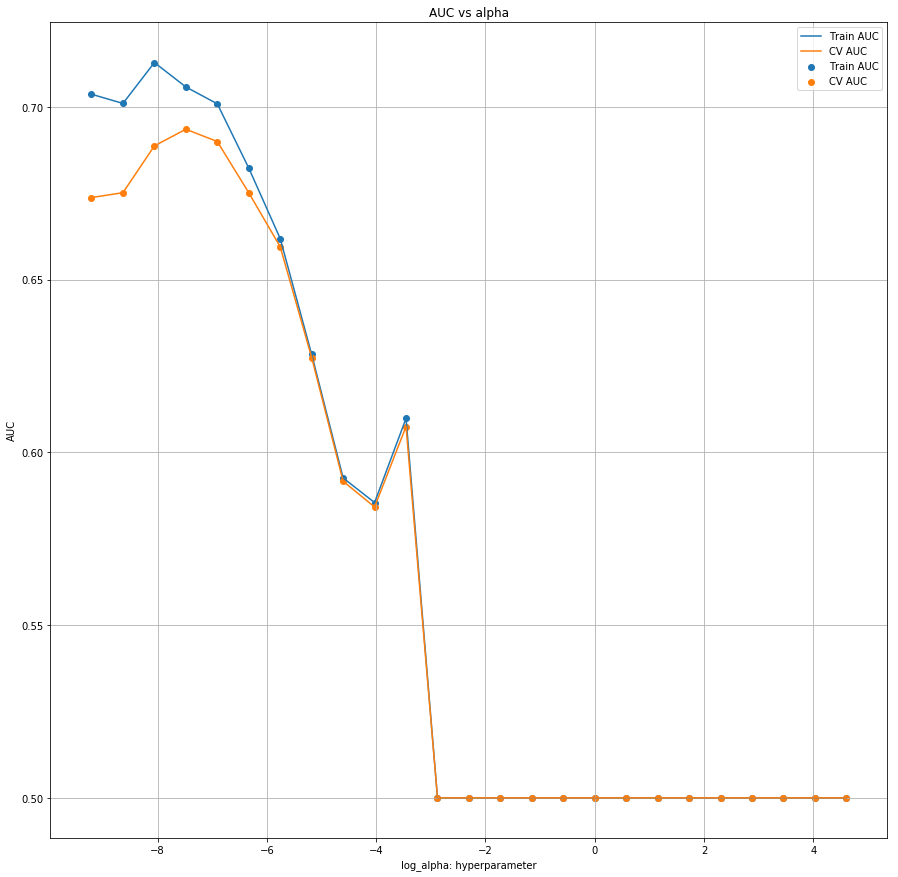

In [213]:
from sklearn.linear_model import SGDClassifier 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import math
alpha1=[]
train_auc = []
cv_auc = []
alpha=np.logspace(-4,2,25)
for i in tqdm(alpha):
    clf=SGDClassifier(loss='hinge',alpha=i,penalty='l1',class_weight='balanced')
    calibrated=CalibratedClassifierCV(clf ,method='isotonic',cv=3)
    calibrated.fit(X_tr,y_train)
    probs_train=calibrated.predict_proba(X_tr)[:,1]
    probs_cv=calibrated.predict_proba(X_cv)[:,1]
    train_auc.append(roc_auc_score(y_train,probs_train))#roc_auc_score->Compute(ROC AUC) from prediction scores.
    print(roc_auc_score(y_train,probs_train))
    cv_auc.append(roc_auc_score(y_cv, probs_cv))
    print(roc_auc_score(y_cv, probs_cv))
    print("corresponding alpha",i)


for i in alpha:
    j=math.log(i)
    alpha1.append(j)
    
plt.figure(figsize=(15,15))
plt.plot(alpha1, train_auc, label='Train AUC') #Plotting alpha vs auc of train
plt.scatter(alpha1, train_auc, label='Train AUC') #Scatter plot of alpha vs auc train

plt.plot(alpha1, cv_auc, label='CV AUC') #Plotting alpha vs auc of CV
plt.scatter(alpha1, cv_auc, label='CV AUC') #Scatter plot of alpha vs auc of CV

plt.legend() #adding legend
plt.xlabel("log_alpha: hyperparameter") #X axis-label
plt.ylabel("AUC")  #Y-axis label
plt.title("AUC vs alpha") #adding title of the plot
plt.grid()
plt.show()

#### L1 regularization is performing better than L2

### Testing on Test Data(using our best hyper parameter=0.00020691380811147902)

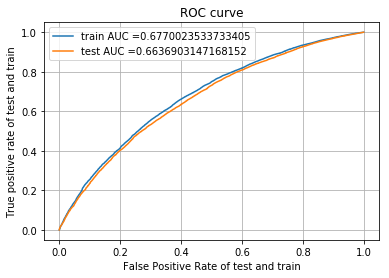

In [214]:
from sklearn.metrics import roc_curve,auc

clf=SGDClassifier(alpha= 0.00020691380811147902 , penalty='l1')
calibrated=CalibratedClassifierCV(clf ,method='isotonic',cv=3)
calibrated.fit(X_tr,y_train)

#documentation of roc_curve ->https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
#roc_curve returns three values fpr,tpr and thresholds
probs_train=calibrated.predict_proba(X_tr)[:,1]
probs_test=calibrated.predict_proba(X_te)[:,1]
train_fpr,train_tpr,train_thresholds= roc_curve(y_train,probs_train)
test_fpr,test_tpr,test_thresholds= roc_curve(y_test,probs_test)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr))) #documentation of auc-> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("False Positive Rate of test and train") #plt.plot documentation ->https://matplotlib.org/3.1.0/tutorials/introductory/pyplot.html
plt.ylabel("True positive rate of test and train")
plt.title("ROC curve")
plt.grid()
plt.show()

### Confusion Matrix

In [215]:

df=pd.DataFrame({"fpr":train_fpr,"tpr":train_tpr,"threshold":train_thresholds})
print(df.head(3))
print(df.shape)

        fpr       tpr  threshold
0  0.000000  0.000000   1.971552
1  0.000000  0.000144   0.971552
2  0.000135  0.000264   0.969825
(5297, 3)


In [216]:
df['Specificty']=1-df.fpr

In [217]:
df['Value']=df.tpr*df.Specificty

In [218]:
df.sort_values("Value", axis = 0, ascending = False, 
                 inplace = True, na_position ='first')

In [219]:
index = df.Value.argmax()

In [220]:
a=df['threshold'][index]
print(a)

0.8420997663608243


In [221]:
from sklearn.preprocessing import binarize
y_predict_thres=binarize(probs_train.reshape(-1,1),a)#changing the threshold and printing the first value
print(y_predict_thres[0])


[1.]


In [222]:
from sklearn.metrics import confusion_matrix
print("Threshold",a)
print("confusion matrix")
cm=confusion_matrix(y_train, y_predict_thres)
print(cm)


Threshold 0.8420997663608243
confusion matrix
[[ 4575  2851]
 [14744 26871]]


Text(0.5, 42.0, 'Predicted')

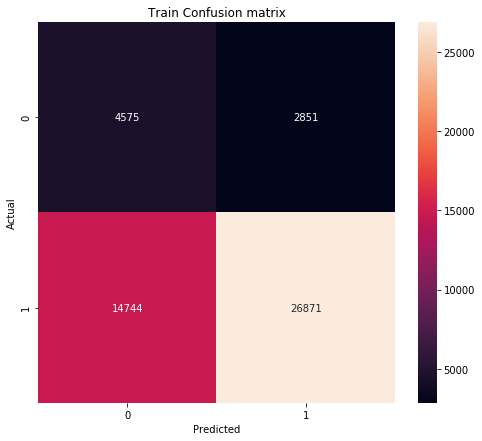

In [223]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

import seaborn as sn
df_cm=pd.DataFrame(cm,index=[0,1],columns=[0,1])
plt.figure(figsize = (8,7))
plt.title("Train Confusion matrix")
ax=sn.heatmap(df_cm, annot=True,fmt='g')
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#### Test Data

In [224]:
from sklearn.preprocessing import binarize
y_predict_thres=binarize(probs_test.reshape(-1,1),a)#changing the threshold and printing the first value
print(y_predict_thres[0])


[1.]


In [225]:
from sklearn.metrics import confusion_matrix
print("Threshold",a)

print("Test confusion matrix")
cm1=confusion_matrix(y_test, y_predict_thres)
print(cm1)


Threshold 0.8420997663608243
Test confusion matrix
[[ 3217  2242]
 [10869 19724]]


Text(0.5, 42.0, 'Predicted')

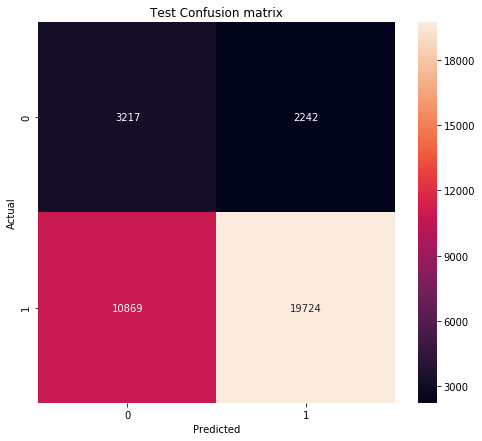

In [226]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

import seaborn as sn
df_cm=pd.DataFrame(cm1,index=[0,1],columns=[0,1])
plt.figure(figsize = (8,7))
plt.title("Test Confusion matrix")
ax=sn.heatmap(df_cm, annot=True,fmt='g')
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#### Reducing Dimensions Using Truncated SVD

In [248]:
from sklearn.feature_extraction.text import TfidfVectorizer
model_essay_tfidf = TfidfVectorizer(max_features=3000)
model_essay_tfidf.fit(X_train["preprocessed_essays"])

train_tfidf_essay=model_essay_tfidf.transform(X_train["preprocessed_essays"])
print("Shape of matrix ",train_tfidf_essay.shape)
print("="*50)
cv_tfidf_essay=model_essay_tfidf.transform(X_cv["preprocessed_essays"]) #tfidf of CV
print("Shape of matrix ",cv_tfidf_essay.shape)
print("="*50)
test_tfidf_essay = model_essay_tfidf.transform(X_test["preprocessed_essays"]) #tfidf of Test
print("Shape of matrix ",test_tfidf_essay.shape)

Shape of matrix  (49041, 3000)
Shape of matrix  (24155, 3000)
Shape of matrix  (36052, 3000)


In [249]:
from sklearn.decomposition import TruncatedSVD

svd=TruncatedSVD(n_components=2999)
svd.fit_transform(train_tfidf_essay)

array([[ 3.57036433e-01,  2.66589532e-01, -2.84098621e-02, ...,
         9.33357228e-04,  1.54296049e-03, -1.93410906e-03],
       [ 2.80472134e-01, -4.37965090e-02, -5.34480876e-02, ...,
        -1.98875303e-03, -2.14971818e-03,  1.55890003e-03],
       [ 2.22402026e-01, -3.91393317e-03, -8.53979064e-03, ...,
        -1.03505102e-04,  1.51844068e-03,  1.68046271e-03],
       ...,
       [ 3.12425196e-01,  1.81727671e-01,  4.10838408e-02, ...,
         2.12848102e-03, -1.38680674e-03, -4.25767961e-03],
       [ 4.38823243e-01, -8.75852983e-02, -4.82514907e-02, ...,
        -1.19467065e-03,  2.35009511e-03,  1.57653100e-03],
       [ 2.34045570e-01,  2.30588829e-01,  4.93737079e-02, ...,
         3.47985942e-03, -8.87755128e-05,  1.51134765e-03]])

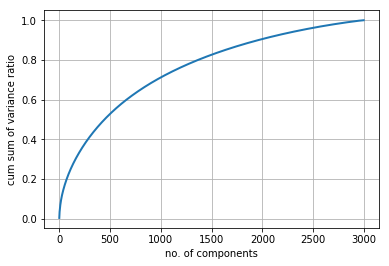

In [250]:
cum_sum=np.cumsum(svd.explained_variance_ratio_)
plt.plot(cum_sum,linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('no. of components')
plt.ylabel('cum sum of variance ratio')
plt.show()

#### 1500 components preserve more than 80% of the variance ratio

In [251]:
from sklearn.decomposition import TruncatedSVD

svd=TruncatedSVD(n_components=1500)
svd.fit(train_tfidf_essay)


svd_train=svd.transform(train_tfidf_essay)
print(svd_train.shape)
print("*"*50)
svd_cv=svd.transform(cv_tfidf_essay)
print(svd_cv.shape)
print("*"*50)
svd_test=svd.transform(test_tfidf_essay)
print(svd_test.shape)
print("*"*50)

(49041, 1500)
**************************************************
(24155, 1500)
**************************************************
(36052, 1500)
**************************************************


## Set 5: Categorical Features,Numerical Features+Preprocessed Essay(using SVD)

In [252]:
from scipy.sparse import hstack

X_tr=hstack((categories_ohe_train,subcategories_ohe_train,state_ohe_train,grade_ohe_train,prefix_ohe_train,price_train,quantity_train,tnp_train,svd_train)).tocsr()

X_cv=hstack((categories_ohe_cv,subcategories_ohe_cv,state_ohe_cv,grade_ohe_cv,prefix_ohe_cv,price_cv,quantity_cv,tnp_cv,svd_cv)).tocsr()

X_te=hstack((categories_ohe_test,subcategories_ohe_test,state_ohe_test,grade_ohe_test,prefix_ohe_test,price_test,quantity_test,tnp_test,svd_test)).tocsr()

In [253]:
#checking the final matrix are of same dimension or not
print(X_tr.shape,y_train.shape)
print("="*50)
print(X_cv.shape,y_cv.shape)
print("="*50)
print(X_te.shape,y_test.shape)

(49041, 1603) (49041,)
(24155, 1603) (24155,)
(36052, 1603) (36052,)


### Using Brute Force for finding best Hyperparameter

#### Using L2 as a Regularization term


  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

0.7377103428342715
0.6930872865325264
corresponding alpha 0.0001



  4%|███▎                                                                               | 1/25 [00:04<01:57,  4.92s/it]

0.7377256065768254
0.6984953052903939
corresponding alpha 0.00017782794100389227



  8%|██████▋                                                                            | 2/25 [00:09<01:52,  4.91s/it]

0.7323744157541239
0.6957787194028654
corresponding alpha 0.00031622776601683794



 12%|█████████▉                                                                         | 3/25 [00:14<01:47,  4.90s/it]

0.7308601308229261
0.6992571395548624
corresponding alpha 0.0005623413251903491



 16%|█████████████▎                                                                     | 4/25 [00:19<01:43,  4.93s/it]

0.712228404805584
0.687674538660581
corresponding alpha 0.001



 20%|████████████████▌                                                                  | 5/25 [00:24<01:38,  4.93s/it]

0.6834745021882616
0.6655340938709267
corresponding alpha 0.0017782794100389228



 24%|███████████████████▉                                                               | 6/25 [00:29<01:34,  4.96s/it]

0.6491418003624791
0.6384577813376646
corresponding alpha 0.0031622776601683794



 28%|███████████████████████▏                                                           | 7/25 [00:34<01:29,  4.99s/it]

0.6161625656859483
0.6112755606614869
corresponding alpha 0.005623413251903491



 32%|██████████████████████████▌                                                        | 8/25 [00:40<01:27,  5.12s/it]

0.5932259966808073
0.5902052430173663
corresponding alpha 0.01



 36%|█████████████████████████████▉                                                     | 9/25 [00:45<01:21,  5.12s/it]

0.578826268677658
0.577615240772738
corresponding alpha 0.01778279410038923



 40%|████████████████████████████████▊                                                 | 10/25 [00:50<01:16,  5.11s/it]

0.5673706389728812
0.5677512893139124
corresponding alpha 0.03162277660168379



 44%|████████████████████████████████████                                              | 11/25 [00:55<01:11,  5.13s/it]

0.5619550893255765
0.5609671383801211
corresponding alpha 0.05623413251903491



 48%|███████████████████████████████████████▎                                          | 12/25 [01:00<01:06,  5.11s/it]

0.5599505217873342
0.5588740218171041
corresponding alpha 0.1



 52%|██████████████████████████████████████████▋                                       | 13/25 [01:05<01:01,  5.10s/it]

0.5599922487239954
0.5584587202235567
corresponding alpha 0.1778279410038923



 56%|█████████████████████████████████████████████▉                                    | 14/25 [01:10<00:56,  5.11s/it]

0.559589642840397
0.5583501173527323
corresponding alpha 0.31622776601683794



 60%|█████████████████████████████████████████████████▏                                | 15/25 [01:15<00:51,  5.11s/it]

0.5596683075810126
0.5584692390005676
corresponding alpha 0.5623413251903491



 64%|████████████████████████████████████████████████████▍                             | 16/25 [01:20<00:45,  5.09s/it]

0.559695209239635
0.5584985675119921
corresponding alpha 1.0



 68%|███████████████████████████████████████████████████████▊                          | 17/25 [01:26<00:40,  5.08s/it]

0.55960422380795
0.5584199401540952
corresponding alpha 1.7782794100389228



 72%|███████████████████████████████████████████████████████████                       | 18/25 [01:31<00:35,  5.09s/it]

0.5596604524326028
0.5584520567750888
corresponding alpha 3.1622776601683795



 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [01:36<00:30,  5.10s/it]

0.5596503871641665
0.5584420916179208
corresponding alpha 5.623413251903491



 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [01:41<00:25,  5.19s/it]

0.5596597292088459
0.5584420916179208
corresponding alpha 10.0



 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [01:46<00:20,  5.21s/it]

0.5596533447772033
0.5584215276423188
corresponding alpha 17.78279410038923



 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [01:52<00:15,  5.21s/it]

0.5596593214853858
0.5584420916179208
corresponding alpha 31.622776601683793



 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [01:57<00:10,  5.26s/it]

0.559668872245646
0.5584420916179208
corresponding alpha 56.23413251903491



 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [02:03<00:05,  5.37s/it]

0.5596683140528136
0.5584420916179208
corresponding alpha 100.0



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:08<00:00,  5.52s/it]

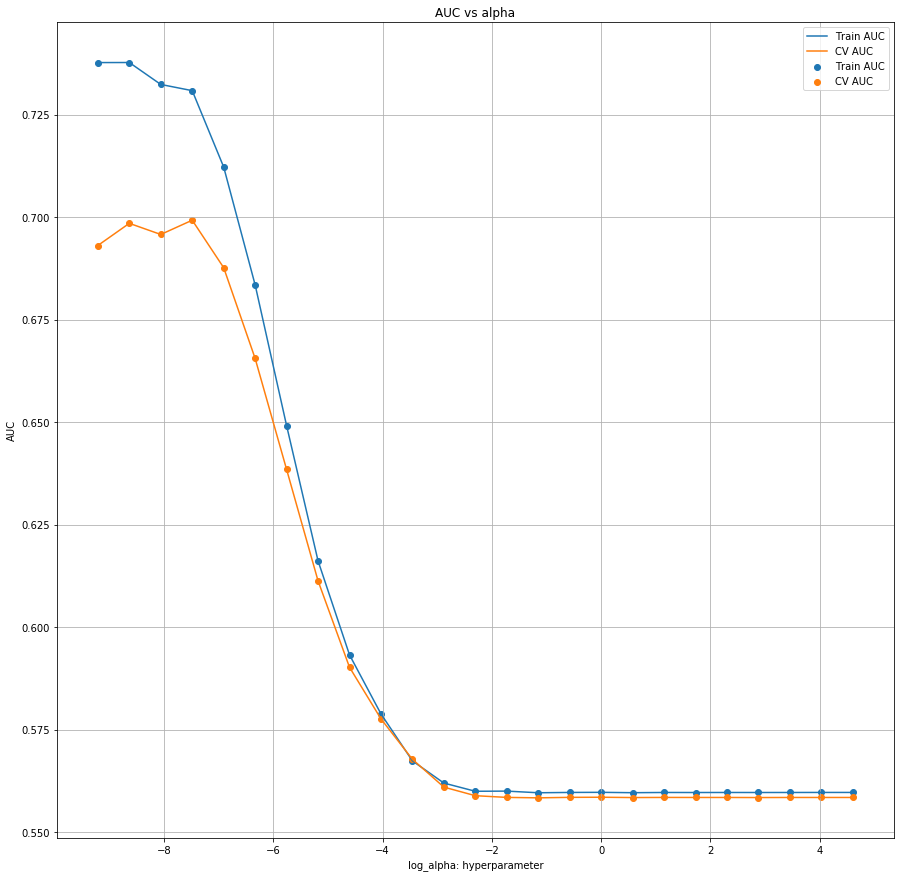

In [254]:
from sklearn.linear_model import SGDClassifier 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import math
alpha1=[]
train_auc = []
cv_auc = []
alpha=np.logspace(-4,2,25)
for i in tqdm(alpha):
    clf=SGDClassifier(loss='hinge',alpha=i,penalty='l2',class_weight='balanced')
    calibrated=CalibratedClassifierCV(clf ,method='isotonic',cv=3)
    calibrated.fit(X_tr,y_train)
    probs_train=calibrated.predict_proba(X_tr)[:,1]
    probs_cv=calibrated.predict_proba(X_cv)[:,1]
    train_auc.append(roc_auc_score(y_train,probs_train))#roc_auc_score->Compute(ROC AUC) from prediction scores.
    print(roc_auc_score(y_train,probs_train))
    cv_auc.append(roc_auc_score(y_cv, probs_cv))
    print(roc_auc_score(y_cv, probs_cv))
    print("corresponding alpha",i)

for i in alpha:
    j=math.log(i)
    alpha1.append(j)
    
plt.figure(figsize=(15,15))
plt.plot(alpha1, train_auc, label='Train AUC') #Plotting alpha vs auc of train
plt.scatter(alpha1, train_auc, label='Train AUC') #Scatter plot of alpha vs auc train

plt.plot(alpha1, cv_auc, label='CV AUC') #Plotting alpha vs auc of CV
plt.scatter(alpha1, cv_auc, label='CV AUC') #Scatter plot of alpha vs auc of CV

plt.legend() #adding legend
plt.xlabel("log_alpha: hyperparameter") #X axis-label
plt.ylabel("AUC")  #Y-axis label
plt.title("AUC vs alpha") #adding title of the plot
plt.grid()
plt.show()

#### Using L1 as a Regularization term


  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

0.7480984861842743
0.7057124069515122
corresponding alpha 0.0001



  4%|███▎                                                                               | 1/25 [00:10<04:01, 10.05s/it]

0.7343640949142679
0.7056838254933693
corresponding alpha 0.00017782794100389227



  8%|██████▋                                                                            | 2/25 [00:20<03:51, 10.04s/it]

0.7149843193116696
0.698418805700326
corresponding alpha 0.00031622776601683794



 12%|█████████▉                                                                         | 3/25 [00:29<03:38,  9.93s/it]

0.6925492614882314
0.682700170992492
corresponding alpha 0.0005623413251903491



 16%|█████████████▎                                                                     | 4/25 [00:39<03:25,  9.78s/it]

0.671207959059646
0.6625294789225986
corresponding alpha 0.001



 20%|████████████████▌                                                                  | 5/25 [00:48<03:13,  9.67s/it]

0.6475546041217153
0.6433546488978976
corresponding alpha 0.0017782794100389228



 24%|███████████████████▉                                                               | 6/25 [00:58<03:03,  9.66s/it]

0.6064496754861027
0.6058254267748645
corresponding alpha 0.0031622776601683794



 28%|███████████████████████▏                                                           | 7/25 [01:07<02:53,  9.66s/it]

0.5633211797225921
0.5661834512596959
corresponding alpha 0.005623413251903491



 32%|██████████████████████████▌                                                        | 8/25 [01:17<02:44,  9.69s/it]

0.5382275740204954
0.5405595170279189
corresponding alpha 0.01



 36%|█████████████████████████████▉                                                     | 9/25 [01:27<02:35,  9.73s/it]

0.5328666447553059
0.5369295317712822
corresponding alpha 0.01778279410038923



 40%|████████████████████████████████▊                                                 | 10/25 [01:37<02:26,  9.79s/it]

0.5
0.5
corresponding alpha 0.03162277660168379



 44%|████████████████████████████████████                                              | 11/25 [01:47<02:17,  9.83s/it]

0.5
0.5
corresponding alpha 0.05623413251903491



 48%|███████████████████████████████████████▎                                          | 12/25 [01:57<02:09,  9.99s/it]

0.5
0.5
corresponding alpha 0.1



 52%|██████████████████████████████████████████▋                                       | 13/25 [02:07<01:59,  9.99s/it]

0.5
0.5
corresponding alpha 0.1778279410038923



 56%|█████████████████████████████████████████████▉                                    | 14/25 [02:17<01:49,  9.98s/it]

0.5
0.5
corresponding alpha 0.31622776601683794



 60%|█████████████████████████████████████████████████▏                                | 15/25 [02:27<01:39,  9.99s/it]

0.5
0.5
corresponding alpha 0.5623413251903491



 64%|████████████████████████████████████████████████████▍                             | 16/25 [02:37<01:29,  9.98s/it]

0.5
0.5
corresponding alpha 1.0



 68%|███████████████████████████████████████████████████████▊                          | 17/25 [02:47<01:19,  9.99s/it]

0.5
0.5
corresponding alpha 1.7782794100389228



 72%|███████████████████████████████████████████████████████████                       | 18/25 [02:57<01:10, 10.00s/it]

0.5
0.5
corresponding alpha 3.1622776601683795



 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [03:07<01:00, 10.05s/it]

0.5
0.5
corresponding alpha 5.623413251903491



 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [03:17<00:50, 10.06s/it]

0.5
0.5
corresponding alpha 10.0



 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [03:27<00:40, 10.02s/it]

0.5
0.5
corresponding alpha 17.78279410038923



 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [03:37<00:30, 10.07s/it]

0.5
0.5
corresponding alpha 31.622776601683793



 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [03:47<00:20, 10.05s/it]

0.5
0.5
corresponding alpha 56.23413251903491



 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [03:57<00:10, 10.03s/it]

0.5
0.5
corresponding alpha 100.0



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [04:08<00:00, 10.03s/it]

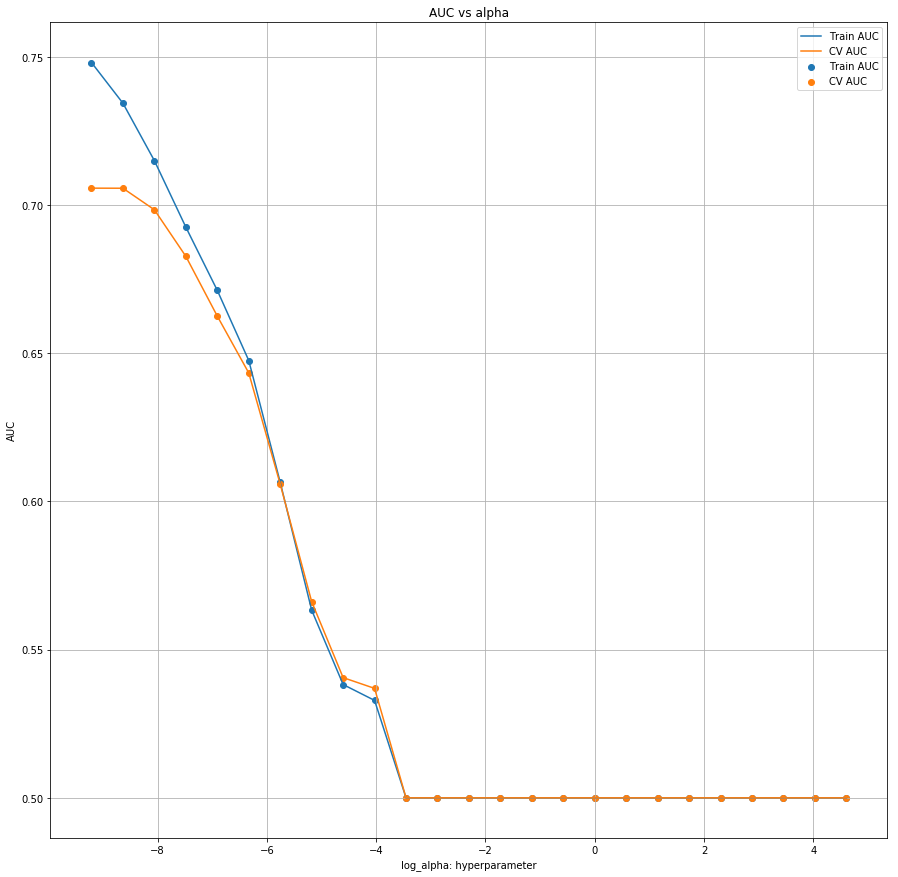

In [255]:
from sklearn.linear_model import SGDClassifier 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import math
alpha1=[]
train_auc = []
cv_auc = []
alpha=np.logspace(-4,2,25)
for i in tqdm(alpha):
    clf=SGDClassifier(loss='hinge',alpha=i,penalty='l1',class_weight='balanced')
    calibrated=CalibratedClassifierCV(clf ,method='isotonic',cv=3)
    calibrated.fit(X_tr,y_train)
    probs_train=calibrated.predict_proba(X_tr)[:,1]
    probs_cv=calibrated.predict_proba(X_cv)[:,1]
    train_auc.append(roc_auc_score(y_train,probs_train))#roc_auc_score->Compute(ROC AUC) from prediction scores.
    print(roc_auc_score(y_train,probs_train))
    cv_auc.append(roc_auc_score(y_cv, probs_cv))
    print(roc_auc_score(y_cv, probs_cv))
    print("corresponding alpha",i)

for i in alpha:
    j=math.log(i)
    alpha1.append(j)
    
plt.figure(figsize=(15,15))
plt.plot(alpha1, train_auc, label='Train AUC') #Plotting alpha vs auc of train
plt.scatter(alpha1, train_auc, label='Train AUC') #Scatter plot of alpha vs auc train

plt.plot(alpha1, cv_auc, label='CV AUC') #Plotting alpha vs auc of CV
plt.scatter(alpha1, cv_auc, label='CV AUC') #Scatter plot of alpha vs auc of CV

plt.legend() #adding legend
plt.xlabel("log_alpha: hyperparameter") #X axis-label
plt.ylabel("AUC")  #Y-axis label
plt.title("AUC vs alpha") #adding title of the plot
plt.grid()
plt.show()

#### L1 regularization is performing better than L2

### Testing on Test Data(using our best hyper parameter= 0.0001)

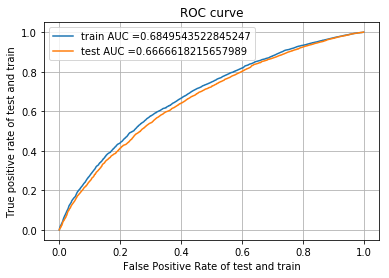

In [256]:
from sklearn.metrics import roc_curve,auc

clf=SGDClassifier(alpha= 0.0001, penalty='l1')
calibrated=CalibratedClassifierCV(clf ,method='isotonic',cv=3)
calibrated.fit(X_tr,y_train)

#documentation of roc_curve ->https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
#roc_curve returns three values fpr,tpr and thresholds
probs_train=calibrated.predict_proba(X_tr)[:,1]
probs_test=calibrated.predict_proba(X_te)[:,1]
train_fpr,train_tpr,train_thresholds= roc_curve(y_train,probs_train)
test_fpr,test_tpr,test_thresholds= roc_curve(y_test,probs_test)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr))) #documentation of auc-> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("False Positive Rate of test and train") #plt.plot documentation ->https://matplotlib.org/3.1.0/tutorials/introductory/pyplot.html
plt.ylabel("True positive rate of test and train")
plt.title("ROC curve")
plt.grid()
plt.show()

### Confusion Matrix

In [257]:
df=pd.DataFrame({"fpr":train_fpr,"tpr":train_tpr,"threshold":train_thresholds})
print(df.head(3))
print(df.shape)

   fpr       tpr  threshold
0  0.0  0.000000   1.989474
1  0.0  0.000024   0.989474
2  0.0  0.000072   0.984568
(5270, 3)


In [258]:
df['Specificty']=1-df.fpr

In [259]:
df['Value']=df.tpr*df.Specificty

In [260]:
df.sort_values("Value", axis = 0, ascending = False, 
                 inplace = True, na_position ='first')

In [261]:
index = df.Value.argmax()


In [262]:
a=df['threshold'][index]
print(a)

0.8475875893907103


In [263]:
from sklearn.preprocessing import binarize
y_predict_thres=binarize(probs_train.reshape(-1,1),a)#changing the threshold and printing the first value
print(y_predict_thres[0])

[1.]


In [264]:
from sklearn.metrics import confusion_matrix
print("Threshold",a)
print("confusion matrix")
cm=confusion_matrix(y_train, y_predict_thres)
print(cm)

Threshold 0.8475875893907103
confusion matrix
[[ 5053  2373]
 [16821 24794]]


Text(0.5, 42.0, 'Predicted')

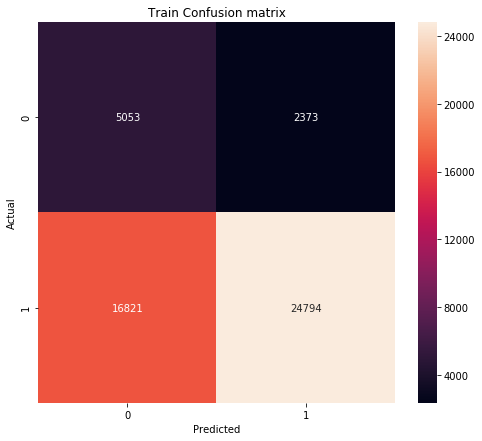

In [265]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

import seaborn as sn
df_cm=pd.DataFrame(cm,index=[0,1],columns=[0,1])
plt.figure(figsize = (8,7))
plt.title("Train Confusion matrix")
ax=sn.heatmap(df_cm, annot=True,fmt='g')
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#### Test Data

In [266]:
from sklearn.preprocessing import binarize
y_predict_thres=binarize(probs_test.reshape(-1,1),a)#changing the threshold and printing the first value
print(y_predict_thres[0])

[1.]


In [267]:
from sklearn.metrics import confusion_matrix
print("Threshold",a)

print("Test confusion matrix")
cm1=confusion_matrix(y_test, y_predict_thres)
print(cm1)

Threshold 0.8475875893907103
Test confusion matrix
[[ 3550  1909]
 [12339 18254]]


Text(0.5, 42.0, 'Predicted')

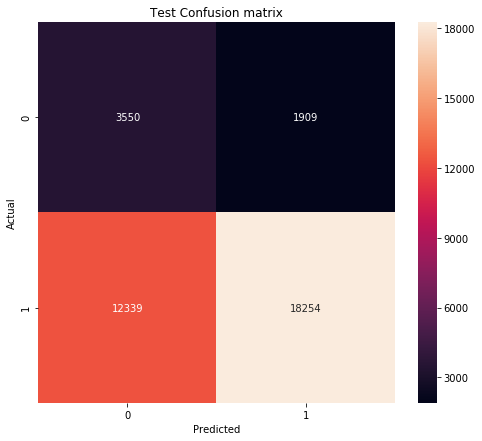

In [268]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

import seaborn as sn
df_cm=pd.DataFrame(cm1,index=[0,1],columns=[0,1])
plt.figure(figsize = (8,7))
plt.title("Test Confusion matrix")
ax=sn.heatmap(df_cm, annot=True,fmt='g')
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

# Summary(Using Pretty Table)

In [271]:
#Refer->http://zetcode.com/python/prettytable/
#Refer->https://het.as.utexas.edu/HET/Software/Numpy/reference/generated/numpy.percentile.html
#Refer->https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.round_.html
from prettytable import PrettyTable
x=PrettyTable()

x.field_names=["SET","Vectorizer", "HyperParameter Search", "Best Hyperparameter(C)","Penaly","Test AUC"] #column headers

x.add_row(["I", "BOW",  "Brute Force", 0.005623413251903491 ,"l2", 0.663])
x.add_row(["II", "TFIDF", "Brute Force",  0.0031622776601683794 ,"l2", 0.547])
x.add_row(["III", "Avg W2V", "Brute Force" ,0.00017782794100389227,"l1", 0.676])
x.add_row(["IV", "TFIDF- W2V" , "Brute Force", 0.00020691380811147902,"l1", 0.663])
x.add_row(["V", "TFIDF(Truncated SVD)", "Brute Force", 0.0001 ,"l1", 0.666])

print(x)

+-----+----------------------+-----------------------+------------------------+--------+----------+
| SET |      Vectorizer      | HyperParameter Search | Best Hyperparameter(C) | Penaly | Test AUC |
+-----+----------------------+-----------------------+------------------------+--------+----------+
|  I  |         BOW          |      Brute Force      |  0.005623413251903491  |   l2   |  0.663   |
|  II |        TFIDF         |      Brute Force      | 0.0031622776601683794  |   l2   |  0.547   |
| III |       Avg W2V        |      Brute Force      | 0.00017782794100389227 |   l1   |  0.676   |
|  IV |      TFIDF- W2V      |      Brute Force      | 0.00020691380811147902 |   l1   |  0.663   |
|  V  | TFIDF(Truncated SVD) |      Brute Force      |         0.0001         |   l1   |  0.666   |
+-----+----------------------+-----------------------+------------------------+--------+----------+
